# Experiments for asynchronous gate and expert training with different datasets

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cm as cm  # colormaps

%matplotlib inline

In [2]:
import seaborn as sns
import numpy as np
from statistics import mean
from math import ceil, sin, cos, radians
from collections import OrderedDict
import os
import pandas as pd
from pprint import pprint
from copy import deepcopy
from itertools import product

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")

else:
    device = torch.device("cpu")
print('device', device)

device cuda:0


In [5]:
# import MoE expectation model. All experiments for this dataset are done with the expectation model as it
# provides the best guarantee of interpretable task decompositions
from moe_models.moe_expectation_model import moe_expectation_model
from helper.moe_models import cross_entropy_loss
from helper.visualise_results import *

device cuda:0
device cuda:0
device cuda:0
device cuda:0


### NOTE: Pre-trained models are provided to check the results of all the experiments if you do not have the time to train all the models. 

In [6]:
# Paths to where the trained models and figures will be stored. You can change this as you see fit.
fig_path = '../figures'
model_path = '../models'
pre_trained_model_path = '../models/pre_trained'

if not os.path.exists(fig_path):
    os.mkdir(fig_path)
if not os.path.exists(model_path):
    os.mkdir(model_path)

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.49,0.48, 0.45), (0.25, 0.24, 0.26))])

In [8]:
cifar10_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
cifar10_testset, cifar10_trainset

Files already downloaded and verified
Files already downloaded and verified


(Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.49, 0.48, 0.45), std=(0.25, 0.24, 0.26))
            ),
 Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.49, 0.48, 0.45), std=(0.25, 0.24, 0.26))
            ))

In [9]:
num_classes = 10

In [10]:
trainsize = 50000
testsize = 10000

In [11]:
batch_size = 128

In [12]:
cifar_trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(cifar10_trainset, range(trainsize)), batch_size=batch_size,
                                          shuffle=True, num_workers=4, pin_memory=True)
cifar_testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(cifar10_testset, range(testsize)), batch_size=batch_size,
                                         shuffle=True, num_workers=4, pin_memory=True)

In [13]:
classes_cifar = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [14]:
#Function to display the images
def plot_colour_images(images_to_plot, titles=None, nrows=None, ncols=6, thefigsize=(18,18)):
    # images_to_plot: list of images to be displayed
    # titles: list of titles corresponding to the images
    # ncols: The number of images per row to display. The number of rows 
    #        is computed from the number of images to display and the ncols
    # theFigsize: The size of the layour of all the displayed images
    
    n_images = images_to_plot.shape[0]
    
    # Compute the number of rows
    if nrows is None:
        nrows = np.ceil(n_images/ncols).astype(int)
    
    fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=thefigsize)
    ax = ax.flatten()
    
    for i in range(n_images):
        img = images_to_plot[i,:,:,:]
        npimg = img.numpy()
        ax[i].imshow(npimg) 
        ax[i].axis('off')  
        if titles is not None and i<10:
            ax[i].set_title(titles[i%10])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

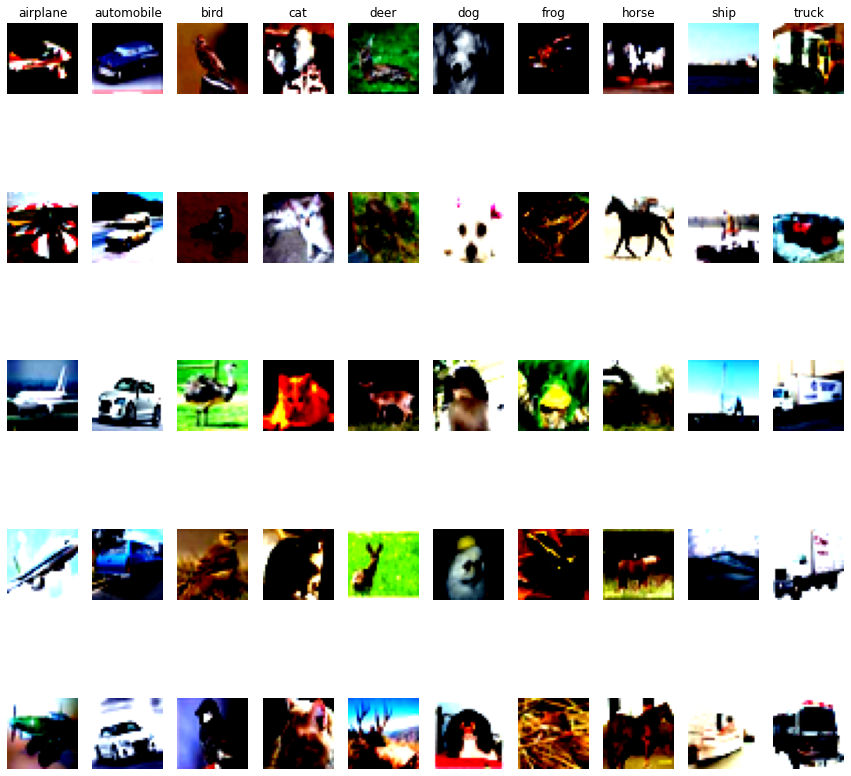

In [15]:
# get some random training images
dataiter = iter(cifar_trainloader)
images, labels = dataiter.next()


images_to_plot = []
for i in range(0, len(classes_cifar)):
    # pick images of each class
    index = np.where(labels==i)[0]
    
    if i == 0:
        images_to_plot.append(images[index[0:5],:,:])
    else:
        images_to_plot.append(images[index[0:5],:,:])

images_to_plot = torch.transpose(torch.stack(images_to_plot),0,1)
new_shape = images_to_plot.shape
images_to_plot = images_to_plot.reshape(new_shape[0]*new_shape[1], new_shape[2], new_shape[3], new_shape[4])
images_to_plot = images_to_plot.permute(0,2,3,1)

plot_colour_images(images_to_plot, nrows=5, ncols=10,thefigsize=(15,15), titles=classes_cifar)
    


## Define expert and gate networks

In [16]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class expert_layers(nn.Module):
    def __init__(self, num_classes):
        super(expert_layers, self).__init__()
        filter_size = 3
        self.filters = 3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.filters, kernel_size=filter_size, padding=1)
        self.conv2 = nn.Conv2d(in_channels=self.filters, out_channels=self.filters*2, kernel_size=filter_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(self.filters*2)
        self.mp = nn.MaxPool2d(2,2)
        
        self.conv3 = nn.Conv2d(in_channels= self.filters*2, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=self.filters*4, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1,bias=False)
        self.bn4 = nn.BatchNorm2d(self.filters*4)

        self.fc1 = nn.Linear(self.filters*4*4*4,64)
        self.fc2 = nn.Linear(64,32)
        
        self.out = nn.Linear(in_features=32, out_features=num_classes)
                
    def forward(self, x):
        # conv 1
        x = self.mp(F.relu(self.conv1(x)))
        x = self.mp(F.relu(self.bn2(self.conv2(x))))

        x = F.relu(self.conv3(x))
        x = self.mp(F.relu(self.bn4(self.conv4(x))))
    
        x = x.reshape(-1, self.filters*4*4*4)
        x = F.relu(self.fc1(x))
        
        x = self.fc2(x)
                      
        self.hidden = x
            
        x = F.relu(x)
                
        # output
        x = F.softmax(self.out(x), dim=1)
        
        return x

In [17]:
# Convolutional network with one convolutional layer and 2 hidden layers with ReLU activation
class gate_attn_layers(nn.Module):
    def __init__(self, num_experts):
        super(gate_attn_layers, self).__init__()
        # define layers
        filter_size = 3
        self.filters = 64
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.filters, kernel_size=filter_size, padding=1)
        self.conv2 = nn.Conv2d(in_channels=self.filters, out_channels=self.filters*2, kernel_size=filter_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(self.filters*2)
        self.mp = nn.MaxPool2d(2,2)
        
        self.conv3 = nn.Conv2d(in_channels= self.filters*2, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=self.filters*4, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1,bias=False)
        self.bn4 = nn.BatchNorm2d(self.filters*4)

        self.fc1 = nn.Linear(self.filters*4*4*4, 512)
        self.fc2 = nn.Linear(512, 32)
                
    def forward(self, x, T=1.0, y=None):
        # conv 1
        x = self.mp(F.relu(self.conv1(x)))
        x = self.mp(F.relu(self.bn2(self.conv2(x))))

        x = F.relu(self.conv3(x))
        x = self.mp(F.relu(self.bn4(self.conv4(x))))
        
        x = x.reshape(-1, self.filters*4*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


In [18]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class gate_layers(nn.Module):
    def __init__(self, num_experts):
        super(gate_layers, self).__init__()
        # define layers
        filter_size = 3
        self.filters = 64
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.filters, kernel_size=filter_size, padding=1)
        self.conv2 = nn.Conv2d(in_channels=self.filters, out_channels=self.filters*2, kernel_size=filter_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(self.filters*2)
        self.mp = nn.MaxPool2d(2,2)
        
        self.conv3 = nn.Conv2d(in_channels= self.filters*2, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=self.filters*4, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1,bias=False)
        self.bn4 = nn.BatchNorm2d(self.filters*4)

        self.fc1 = nn.Linear(self.filters*4*4*4, 512)
        self.fc2 = nn.Linear(512, 32)
        
        self.out = nn.Linear(in_features=32, out_features=num_experts)
        
    def forward(self, t, T=1.0, y=None):
        # conv 1        
        
        x = self.mp(F.relu(self.conv1(x)))
        x = self.mp(F.relu(self.bn2(self.conv2(x))))

        x = F.relu(self.conv3(x))
        x = self.mp(F.relu(self.bn4(self.conv4(x))))
        
        x = x.reshape(-1, self.filters*4*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = self.out(x)
        x = F.softmax(x/T, dim=1)
        return t


In [19]:
# create a set of experts
def experts(num_experts, num_classes, expert_layers_type=expert_layers):
    models = []
    for i in range(num_experts):
        models.append(expert_layers_type(num_classes))
    return nn.ModuleList(models)

## Initialize configurations and helper functions

In [20]:
def accuracy(out, yb, mean=True):
    preds = torch.argmax(out, dim=1).to(device, non_blocking=True)
    if mean:
        return (preds == yb).float().mean()
    else:
        return (preds == yb).float()

## Funtion to train MoR in: 
### (1) dual temp mode where experts and gates are trained with different temperatures
### (2) with regularization
### (3) dual temp and regularization
### (4) without regularization when w_importance = 0.
### (5) training the whole model end-to-end when T = 0.

### NOTE: when importance is set to 0 then it is the default training without regularization

In [21]:
def train_with_attention(model_1, trainloader, testloader, runs, temps=[1.0]*20, 
                                         w_importance_range=[0.0], w_sample_sim_same_range=[0.0], 
                                         w_sample_sim_diff_range=[0.0], w_exp_gamma_range=[0.0],
                                         num_classes=10, total_experts=5, num_epochs=20):
    
    hidden = 32
    
    for T, w_importance, w_sample_sim_same, w_sample_sim_diff, w_exp_gamma in product(temps, w_importance_range, w_sample_sim_same_range,  w_sample_sim_diff_range, 
                                                                       w_exp_gamma_range):
        
        print('Temperature',['{:.1f}'.format(t) for t in T])
        print('w_importance','{:.1f}'.format(w_importance))
        if w_sample_sim_same < 1:
            print('w_sample_sim_same',str(w_sample_sim_same))
        else:
            print('w_sample_sim_same','{:.1f}'.format(w_sample_sim_same))
        
        if w_sample_sim_diff < 1:
            print('w_sample_sim_diff',str(w_sample_sim_diff))
        else:
            print('w_sample_sim_diff','{:.1f}'.format(w_sample_sim_diff))

        if w_exp_gamma < 1:
            print('w_exp_gamma',str(w_exp_gamma))
        else:
            print('w_exp_gamma','{:.1f}'.format(w_exp_gamma))

        
        for run in range(1, runs+1):

            print('Run:', run)
            
            n_run_models_1 = []
            
            models = {'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss(),
                                               'experts':{}},}
            for key, val in models.items():

                expert_models = experts(total_experts, num_classes).to(device)
                
                gate_model = gate_attn_layers(total_experts).to(device)

                moe_model = val['model'](total_experts, num_classes, attention_flag=1, hidden=hidden, 
                                         experts=expert_models, gate=gate_model).to(device)
                
                optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)
                

                hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe = optimizer_moe,
                                       T = T, w_importance=w_importance, 
                                       accuracy=accuracy, epochs=num_epochs)
                val['experts'][total_experts] = {'model':moe_model, 'history':hist}

            # Save all the trained models
            plot_file = generate_plot_file(model_1, T[0], w_importance=w_importance, w_sample_sim_same=w_sample_sim_same,w_sample_sim_diff=w_sample_sim_diff,
                                           specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')
            
            if os.path.exists(os.path.join(model_path, plot_file)):
                n_run_models_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'))
            n_run_models_1.append(models)
            torch.save(n_run_models_1,open(os.path.join(model_path, plot_file),'wb'))
            n_run_models_1 = []
            

In [22]:
def train_from_model(m, num_epochs, num_classes, total_experts, w_importance_range=[0.0], trainloader=None, testloader=None, no_grad=True):
    
    T = [1.0]*num_epochs
    for w_importance in w_importance_range:
        
        plot_file = generate_plot_file(m, temp=T[0], w_importance=w_importance,                                
                               specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

        attn_models = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

        n_run_models_1 = []
        run = 0
        for model in attn_models: 
            run+=1
            print('Run:', run)
            new_expert_models = experts(total_experts, num_classes).to(device)
            old_expert_models = model['moe_expectation_model']['experts'][total_experts]['model'].experts
            for i, expert in enumerate(new_expert_models):
                old_expert = old_expert_models[i]
                expert.load_state_dict(old_expert.state_dict())
                if no_grad:
                    for param in expert.parameters():
                        param.requires_grad = False

            new_gate_model = gate_layers(total_experts).to(device)
            old_gate_model = model['moe_expectation_model']['experts'][total_experts]['model'].gate
            new_gate_model.load_state_dict(old_gate_model.state_dict(), strict=False)
            # print(new_gate_model.train())
            print()
            if no_grad:
                gate_modules = [module for module in new_gate_model.modules() if not isinstance(module, gate_layers)]
                for i in range(0,len(gate_modules)-1):
                    for param in gate_modules[i].parameters():
                        param.requires_grad = True

            models = {'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss(),
                                           'experts':{}},}

            for key, val in models.items():

                # gate_model = gate_layers(total_experts).to(device)

                moe_model = val['model'](total_experts, num_classes,
                                         experts=new_expert_models, gate=new_gate_model).to(device)

                optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)


                hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe = optimizer_moe,
                                       T = T, accuracy=accuracy, epochs=num_epochs)
                val['experts'][total_experts] = {'model':moe_model, 'history':hist}

            n_run_models_1.append(models)

        plot_file = generate_plot_file('new_'+m, T[0], w_importance=w_importance, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')
        print(plot_file)
        torch.save(n_run_models_1,open(os.path.join(model_path, plot_file),'wb'))


## Experiment 1: MoE model training with attention

### CIFAR data

In [23]:
# Model with gate and expert parameters initialized to default values
model_1 = 'cifar_with_attention'

In [24]:
total_experts = 5

In [25]:
num_epochs = 20

In [26]:
temps = [[1.0]*num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [27]:
runs = 4

In [28]:
train_with_attention(model_1, cifar_trainloader, cifar_testloader, runs, temps, num_classes=num_classes, 
                     total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
w_exp_gamma 0.0
Run: 1
epoch 0 training loss 1.71 , training accuracy 0.38 , test accuracy 0.47
epoch 1 training loss 1.35 , training accuracy 0.52 , test accuracy 0.54
epoch 2 training loss 1.21 , training accuracy 0.57 , test accuracy 0.58
epoch 3 training loss 1.11 , training accuracy 0.61 , test accuracy 0.61
epoch 4 training loss 1.03 , training accuracy 0.64 , test accuracy 0.63
epoch 5 training loss 0.96 , training accuracy 0.67 , test accuracy 0.64
epoch 6 training loss 0.91 , training accuracy 0.69 , test accuracy 0.65
epoch 7 training loss 0.86 , training accuracy 0.71 , test accuracy 0.66
epoch 8 training loss 0.80 , training accuracy 0.73 , test accuracy 0.67
epoch 9 training loss 0.76 , training accuracy 0.74 , test accuracy 0.69
epoch 10 training loss 0.71 , tra

## Experiment 2: MoE model training with attention and gate regularization

### CIFAR data

In [30]:
# Model with gate and expert parameters initialized to default values
model_2 = 'cifar_with_attn_reg'

In [31]:
total_experts = 5

In [32]:
num_epochs = 20

In [33]:
temps = [[1.0]*num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [34]:
w_importance_range = [i * 0.2 for i in range(3, 6)]
w_importance_range = [1.0]
w_importance_range

[1.0]

In [35]:
runs = 10

In [36]:
train_with_attention(model_2, cifar_trainloader, cifar_testloader, runs, temps, w_importance_range, 
                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 1.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
w_exp_gamma 0.0
Run: 1
epoch 0 training loss 1.56 , training accuracy 0.44 , test accuracy 0.53
epoch 1 training loss 1.19 , training accuracy 0.59 , test accuracy 0.59
epoch 2 training loss 1.04 , training accuracy 0.65 , test accuracy 0.64
epoch 3 training loss 0.94 , training accuracy 0.69 , test accuracy 0.65
epoch 4 training loss 0.86 , training accuracy 0.72 , test accuracy 0.68
epoch 5 training loss 0.78 , training accuracy 0.75 , test accuracy 0.69
epoch 6 training loss 0.72 , training accuracy 0.77 , test accuracy 0.69
epoch 7 training loss 0.66 , training accuracy 0.79 , test accuracy 0.71
epoch 8 training loss 0.62 , training accuracy 0.81 , test accuracy 0.71
epoch 9 training loss 0.57 , training accuracy 0.83 , test accuracy 0.72
epoch 10 training loss 0.52 , tra

## Experiment 3: MoE model training with attention and sample similarity regularization

### CIFAR data

In [23]:
# Model with gate and expert parameters initialized to default values
model_2 = 'cifar_with_attn_reg'

In [24]:
total_experts = 5

In [25]:
num_epochs = 20

In [26]:
temps = [[1.0]*num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [27]:
w_sample_sim_same_range = [1e-6]
w_sample_sim_diff_range = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
w_sample_sim_same_range, w_sample_sim_diff_range

([1e-06], [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1])

In [28]:
runs = 6

In [ ]:
train_with_attention(model_2, cifar_trainloader, cifar_testloader, runs, temps, 
                     w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range, 
                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_sample_sim_same 1e-06
w_sample_sim_diff 1e-06
w_exp_gamma 0.0
Run: 1
epoch 0 training loss 1.56 , training accuracy 0.44 , test accuracy 0.51
epoch 1 training loss 1.20 , training accuracy 0.58 , test accuracy 0.59
epoch 2 training loss 1.05 , training accuracy 0.64 , test accuracy 0.63
epoch 3 training loss 0.94 , training accuracy 0.68 , test accuracy 0.65
epoch 4 training loss 0.85 , training accuracy 0.72 , test accuracy 0.67
epoch 5 training loss 0.78 , training accuracy 0.74 , test accuracy 0.69
epoch 6 training loss 0.72 , training accuracy 0.76 , test accuracy 0.71
epoch 7 training loss 0.66 , training accuracy 0.78 , test accuracy 0.71
epoch 8 training loss 0.60 , training accuracy 0.81 , test accuracy 0.72
epoch 9 training loss 0.55 , training accuracy 0.83 , test accuracy 0.73
epoch 10 training loss 0.51 ,

## Results

### Expert Usage

In [34]:
cifar_testloader_for_results = torch.utils.data.DataLoader(torch.utils.data.Subset(cifar10_testset, range(2000)), batch_size=testsize,
                                         shuffle=True, num_workers=1, pin_memory=True)

Min Validation Error 0.272
Mutual Information 2.041
Sample Entropy 0.085
Expert Usage 2.114
cifar_with_attention_10_5_models.pt


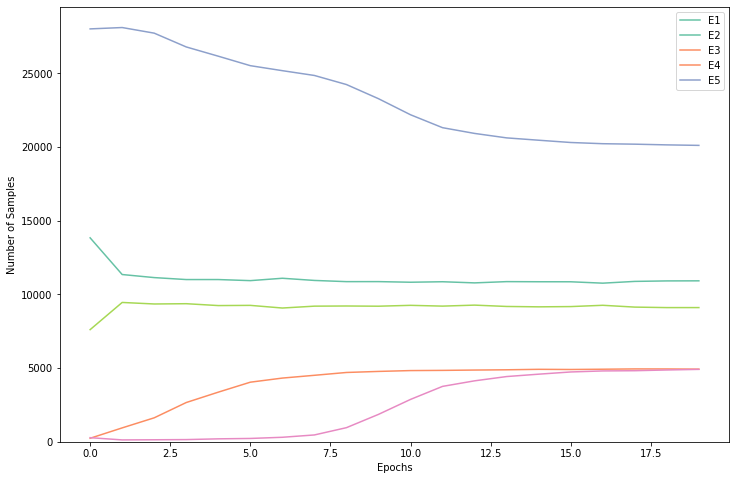

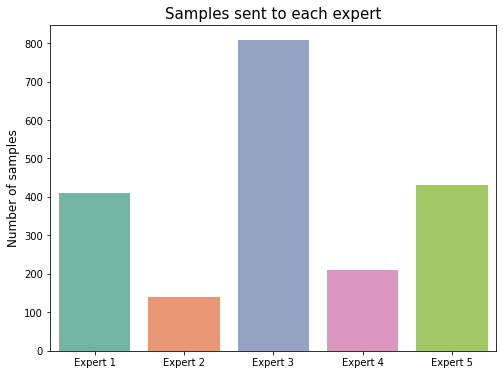

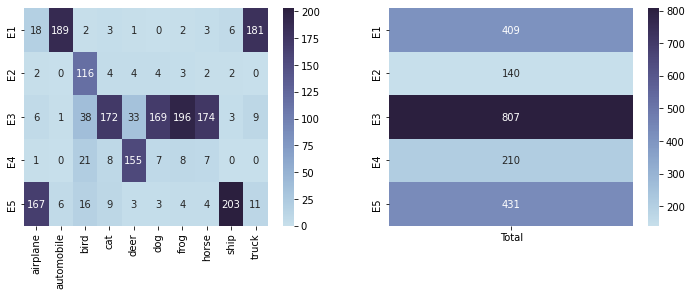


Experts used by the gate for classification of each digit


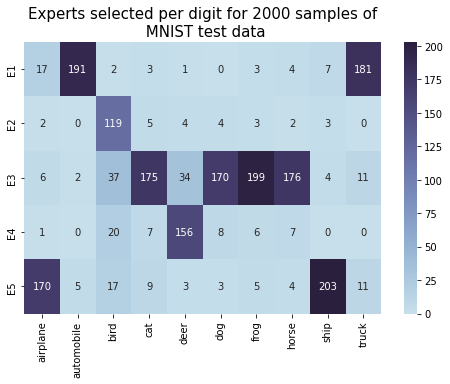

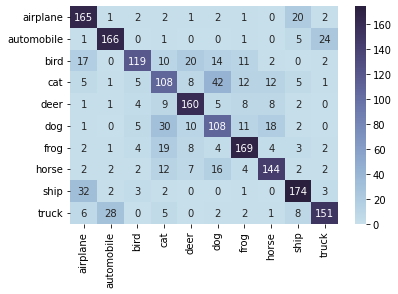

In [35]:
m = 'cifar_with_attention'
test_loader = cifar_testloader_for_results
plot_expert_usage(m, test_loader, w_importance_range=[0.0],classes=classes_cifar, fig_path=fig_path, model_path=model_path)

Min Validation Error 0.054
mnist_with_attn_reg_hidden_32_importance_0.6_10_5_models.pt
20 torch.Size([20, 10000, 5])


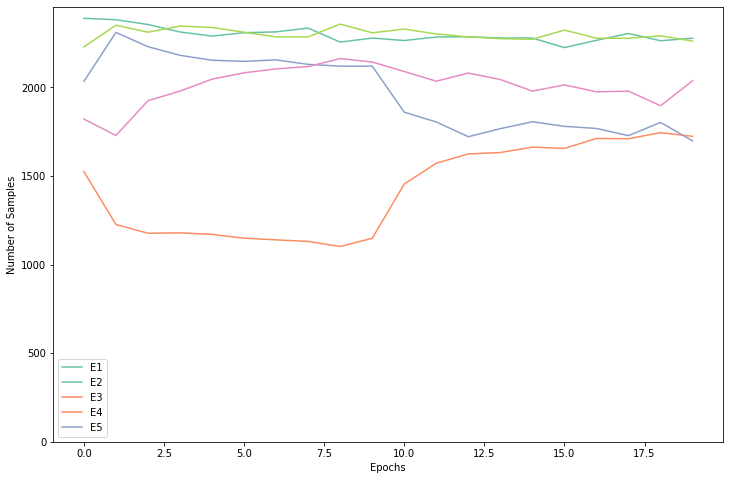

tensor([7, 2, 1,  ..., 3, 9, 5])


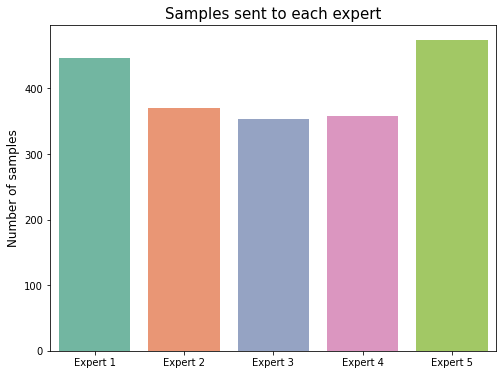

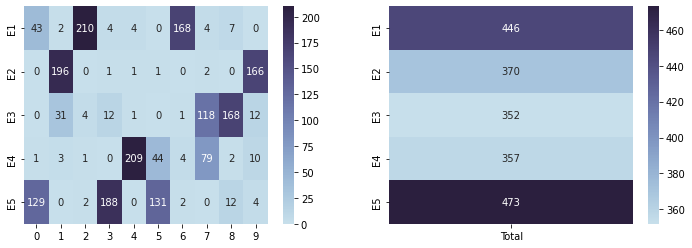


Experts used by the gate for classification of each digit


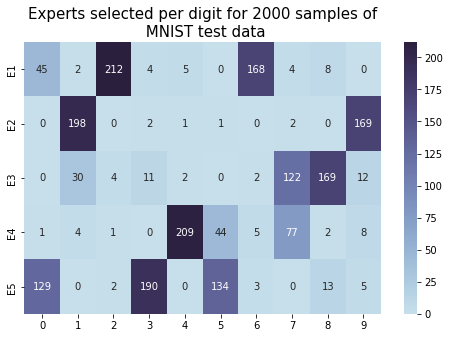

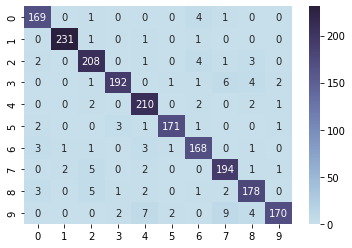

In [52]:
m = 'mnist_with_attn_reg_hidden_32'
test_loader = testloader
w_importance_range = [i * 0.2 for i in range(1, 6)]
plot_expert_usage(m, test_loader, w_importance_range=w_importance_range,classes=range(10),fig_path=fig_path, model_path=model_path )

new_mnist_with_attn_reg_hidden_32_no_grad_10_5_models.pt
20 torch.Size([20, 10000, 5])


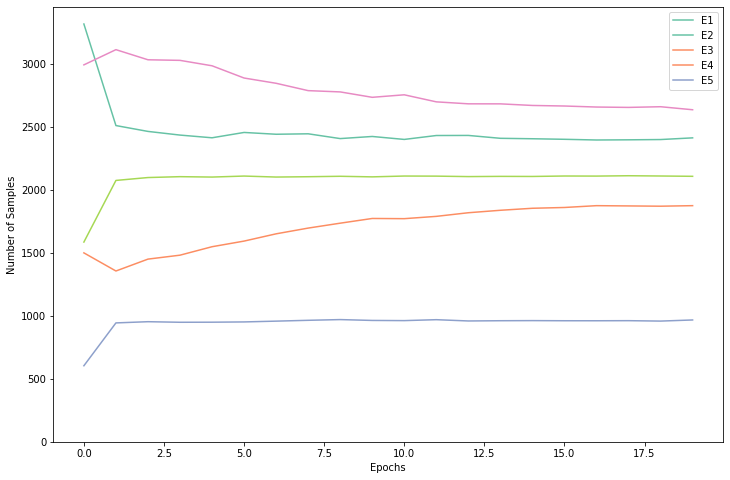

tensor([7, 2, 1,  ..., 3, 9, 5])


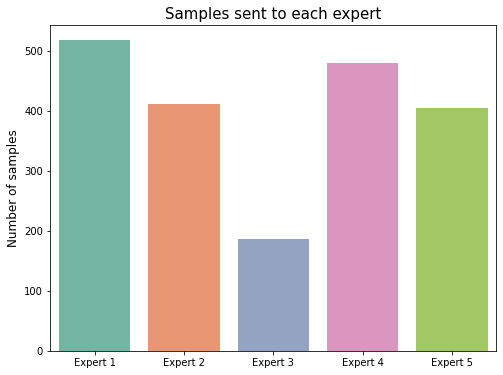

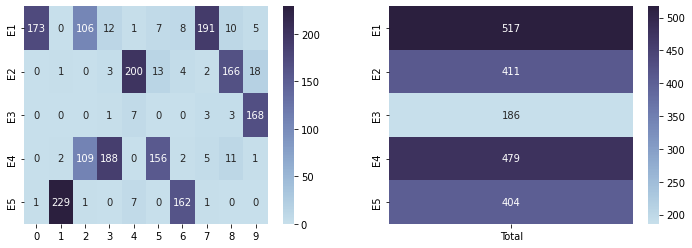


Experts used by the gate for classification of each digit


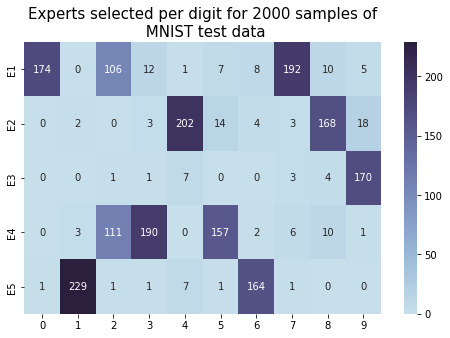

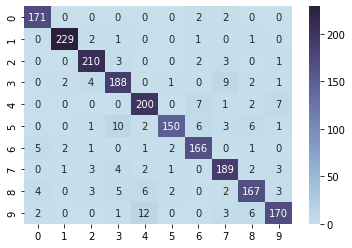

In [110]:
m = 'new_mnist_with_attn_reg_hidden_32_no_grad'
test_loader = testloader
plot_expert_usage(m, test_loader, classes=range(10) )

new_mnist_with_attn_reg_hidden_32_with_grad_10_5_models.pt
20 torch.Size([20, 10000, 5])


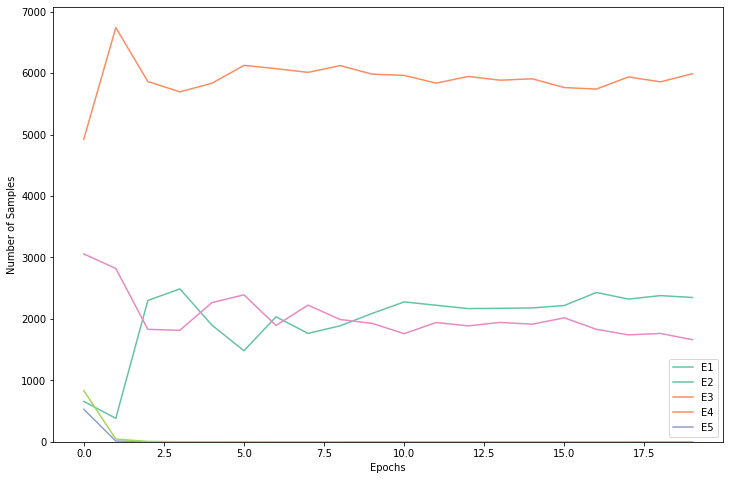

tensor([7, 2, 1,  ..., 3, 9, 5])


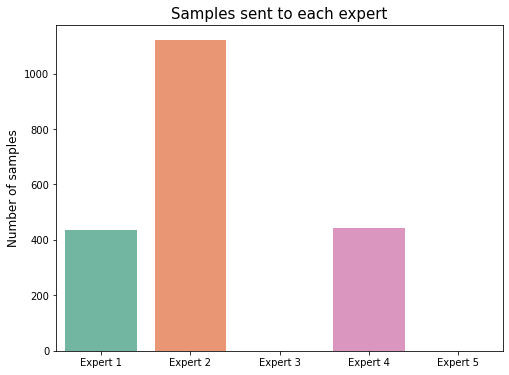

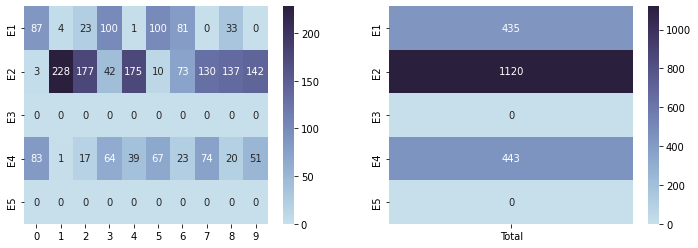


Experts used by the gate for classification of each digit


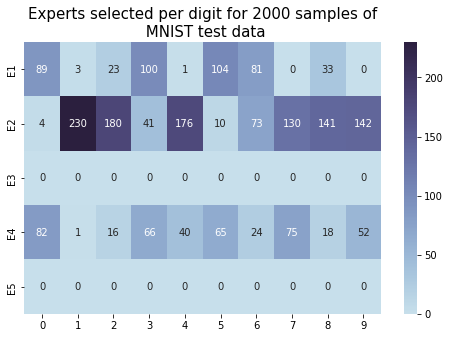

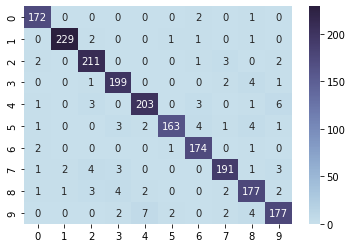

In [68]:
m = 'new_mnist_with_attn_reg_hidden_32_with_grad'
test_loader = testloader
plot_expert_usage(m, test_loader, classes=range(10) )

Min Validation Error 0.026
rot_mnist_with_attn_reg_hidden_32_importance_0.4_10_5_models.pt
20 torch.Size([20, 10000, 5])


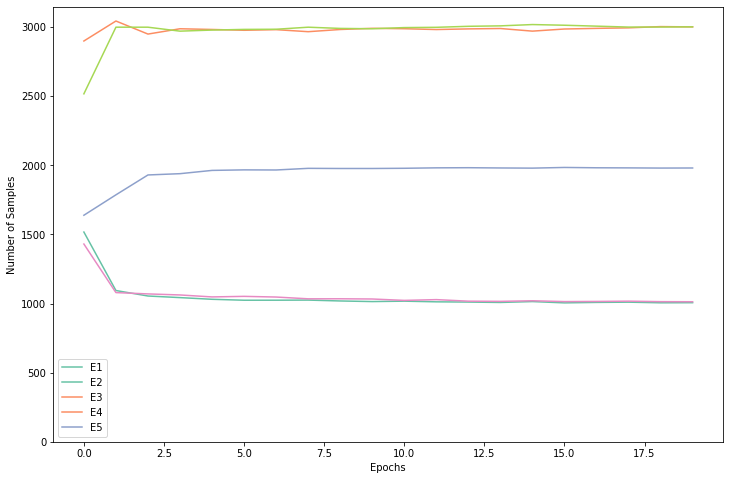

tensor([3, 4, 8,  ..., 0, 4, 6])


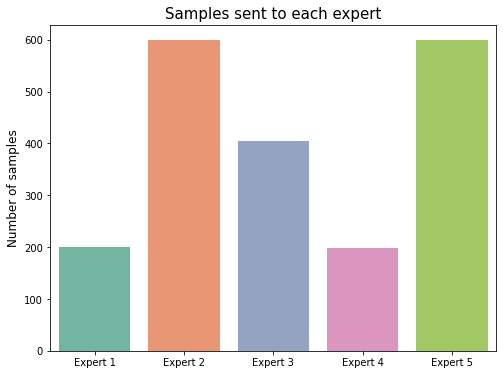

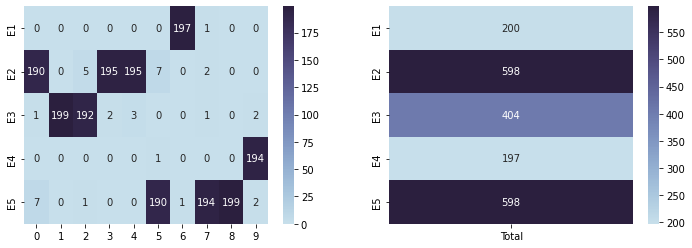


Experts used by the gate for classification of each digit


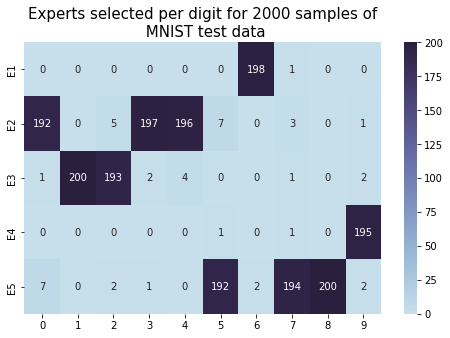

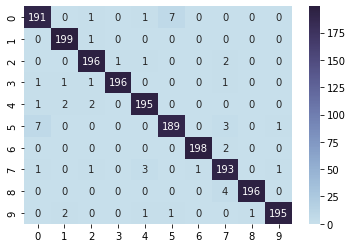

In [61]:
m = 'rot_mnist_with_attn_reg_hidden_32'
test_loader = rot_unrot_testloader
w_importance_range = [i * 0.2 for i in range(1, 6)]
plot_expert_usage(m, test_loader, w_importance_range=w_importance_range,classes=range(10),fig_path=fig_path, model_path=model_path )

Min Validation Error 0.067
fmnist_mnist_with_reg_hidden_32_importance_0.6_12_6_models.pt
20 torch.Size([20, 10000, 6])


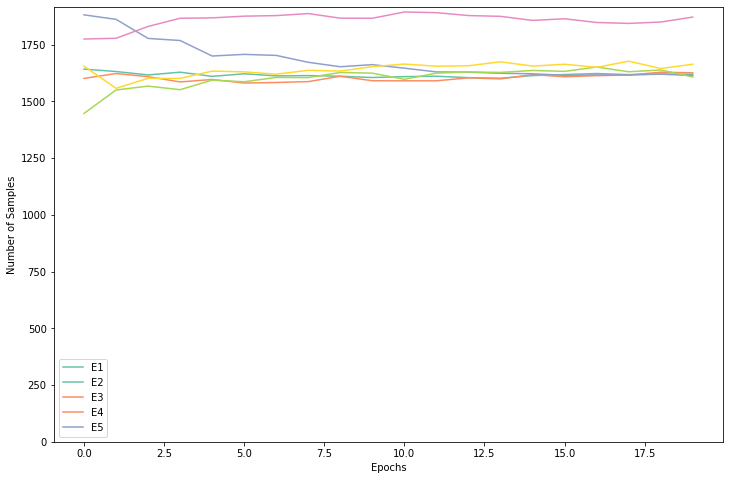

tensor([ 8, 11,  9,  ...,  4,  8,  8])


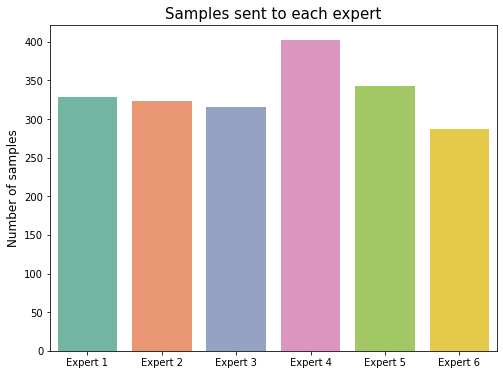

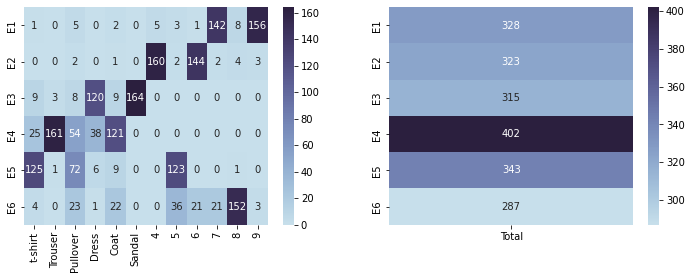


Experts used by the gate for classification of each digit


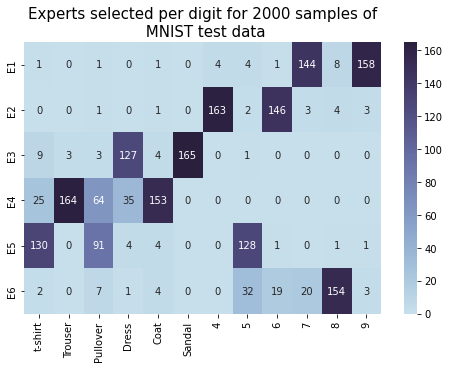

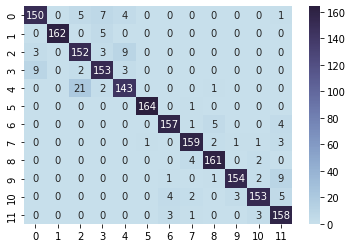

In [63]:
m = 'fmnist_mnist_with_reg_hidden_32'
test_loader = fmnist_mnist_testloader
w_importance_range = [i * 0.2 for i in range(1, 6)]
plot_expert_usage(m, test_loader, w_importance_range=w_importance_range,total_experts=6, num_classes=num_classes_fmnist_mnist, classes=classes_fmnist_mnist,
                  fig_path=fig_path, model_path=model_path )

Min Validation Error 0.071
fmnist_mnist_with_attn_reg_hidden_32_importance_0.2_12_6_models.pt
20 torch.Size([20, 10000, 6])


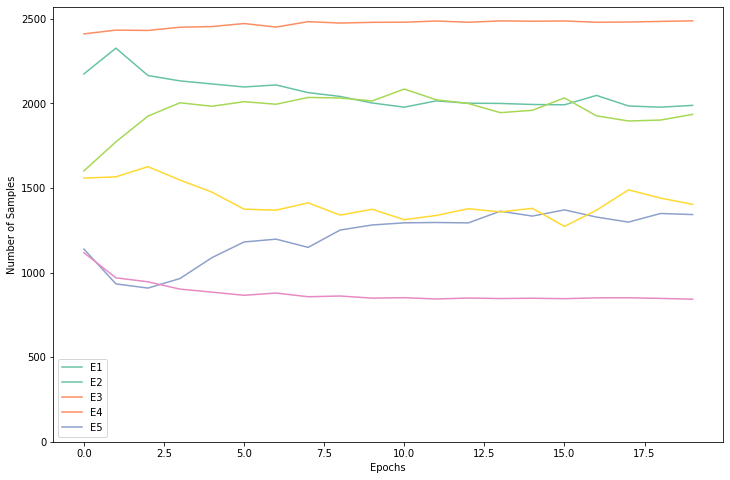

tensor([6, 8, 5,  ..., 1, 1, 8])


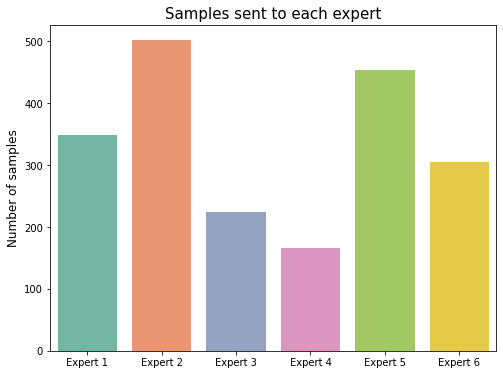

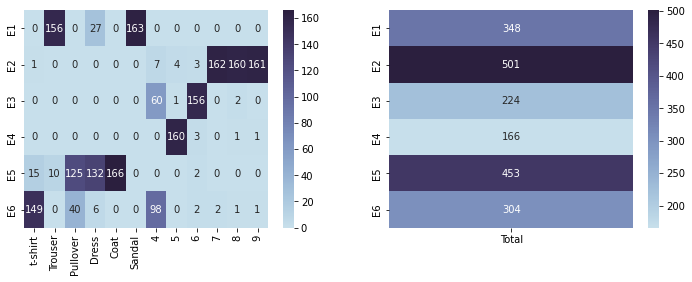


Experts used by the gate for classification of each digit


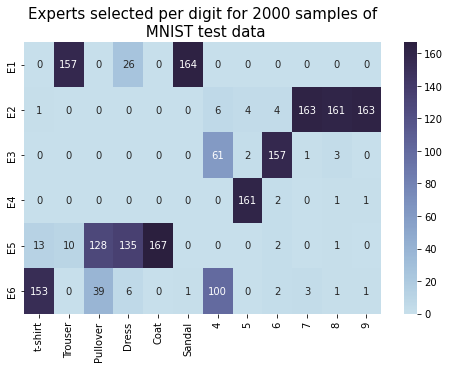

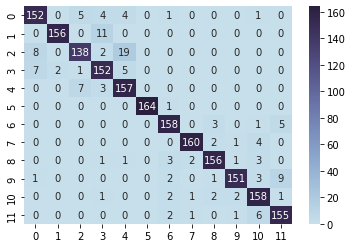

In [62]:
m = 'fmnist_mnist_with_attn_reg_hidden_32'
test_loader = fmnist_mnist_testloader
w_importance_range = [i * 0.2 for i in range(1, 6)]
plot_expert_usage(m, test_loader, w_importance_range=w_importance_range,total_experts=6, num_classes=num_classes_fmnist_mnist, classes=classes_fmnist_mnist,
                  fig_path=fig_path, model_path=model_path )

### Boxplots to compare multiple runs of different models

<Figure size 432x288 with 0 Axes>

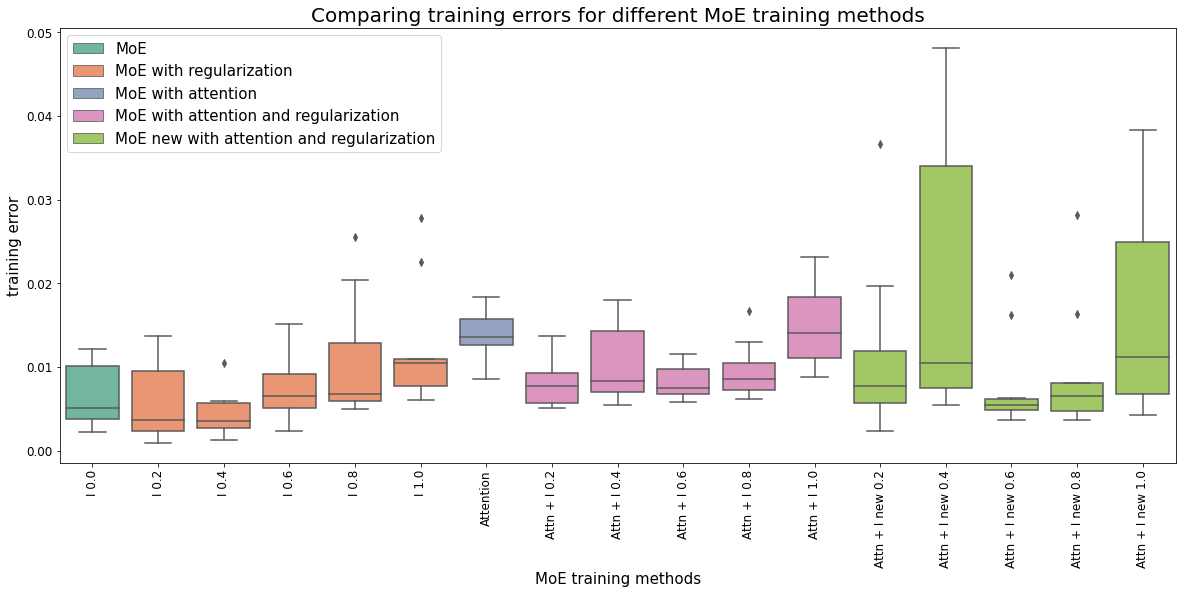

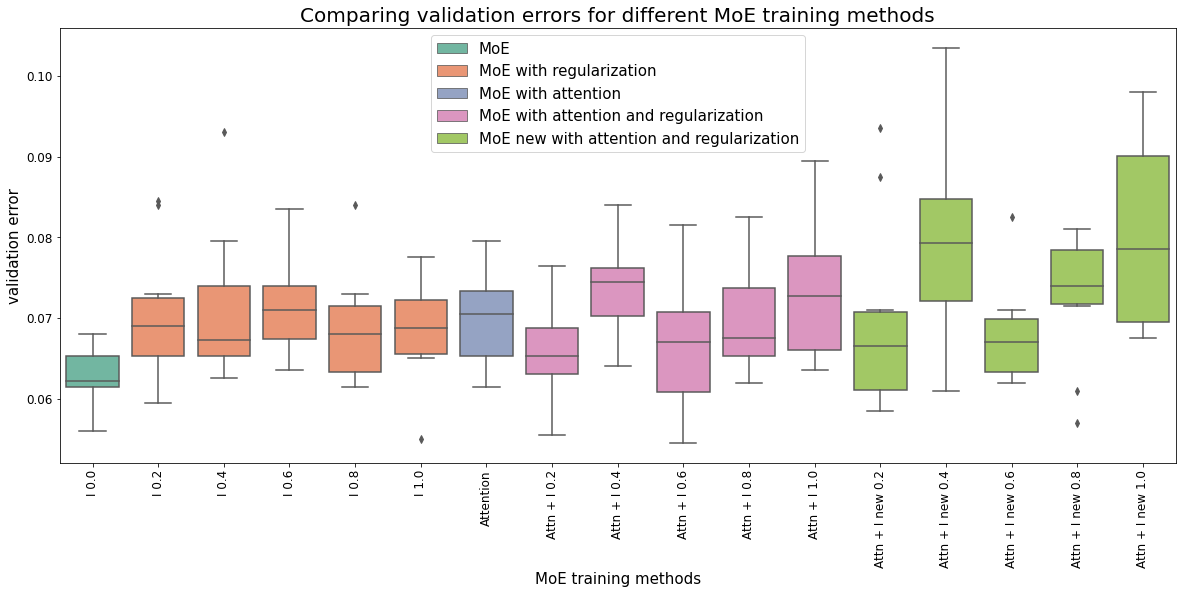

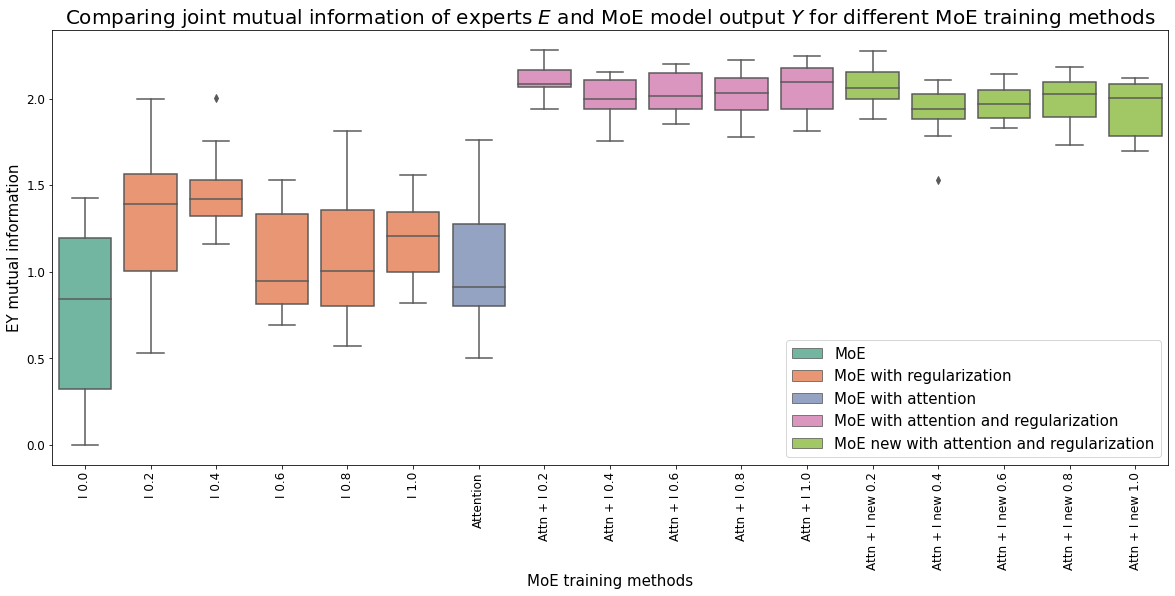

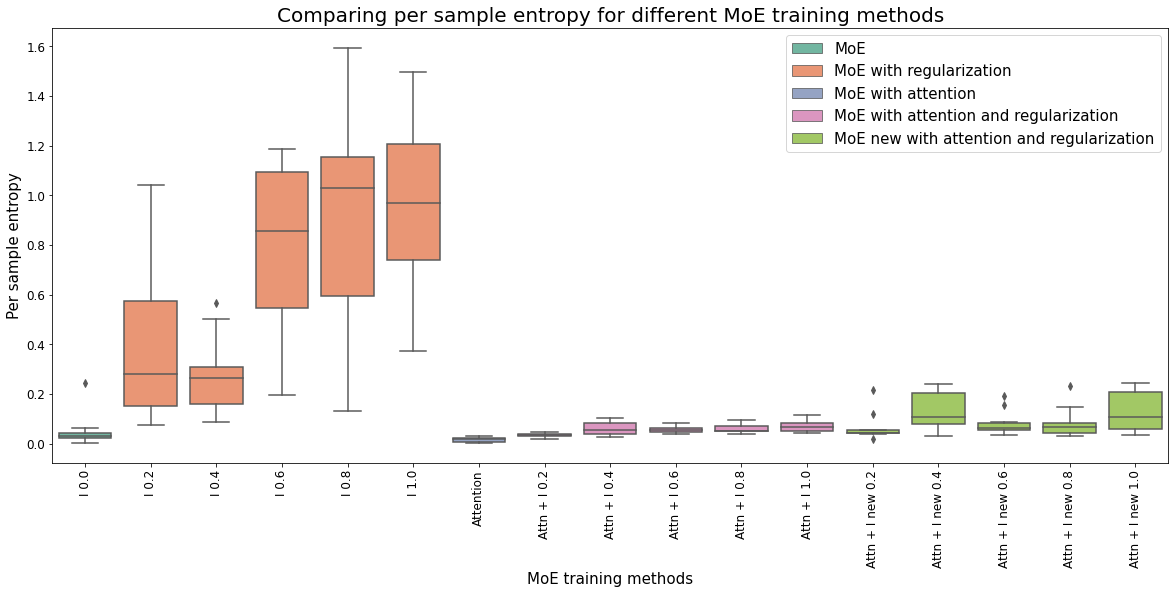

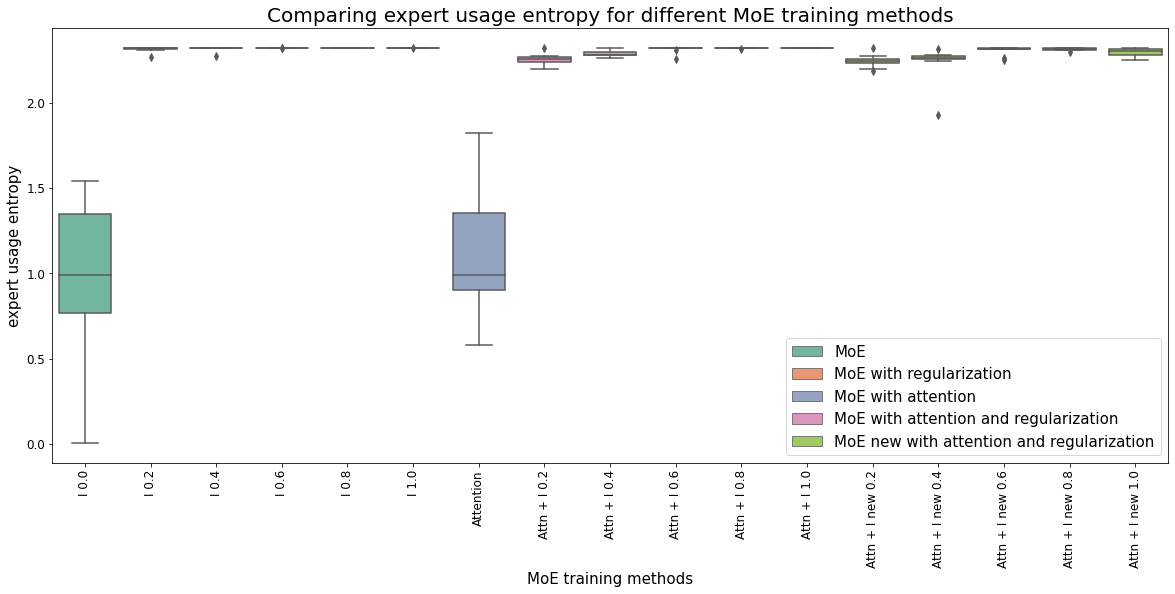

In [87]:
model_with_attention = {'ignore':'mnist_with_attention_hidden_32'}
model_with_attn_reg = {'ignore':'mnist_with_attn_reg_hidden_32', 'new':'new_mnist_with_attn_reg_hidden_32'}
model_with_reg = {'ignore':'mnist_with_reg_hidden_32'}
model_without_reg = {'ignore':'mnist_without_reg_hidden_32'}

figname='mnist_with_attention_hidden_32' 

total_experts = 5
num_classes = 10

w_importance_range = [i * 0.2 for i in range(1, 6)]

boxplot(model_with_reg=model_with_reg, model_without_reg=model_without_reg, model_with_attention=model_with_attention, model_with_attn_reg=model_with_attn_reg,
        w_importance_range=w_importance_range, total_experts=total_experts, num_classes=num_classes, classes=classes_rot_unrot_mnist, 
        testloader=rot_unrot_testloader, figname=figname , fig_path=fig_path, model_path=model_path)

[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]


<Figure size 432x288 with 0 Axes>

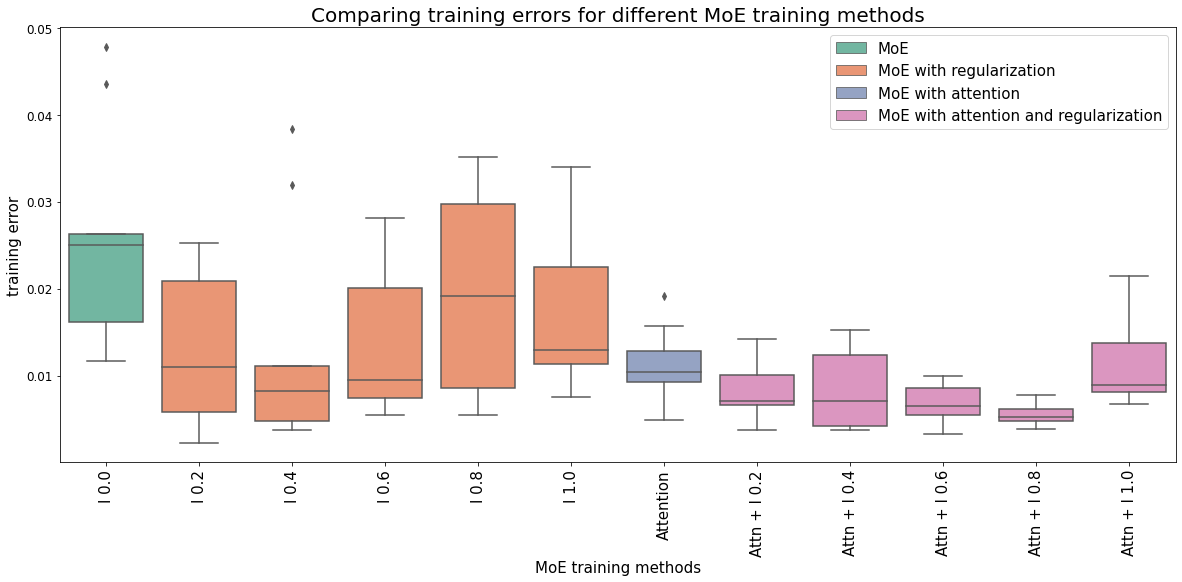

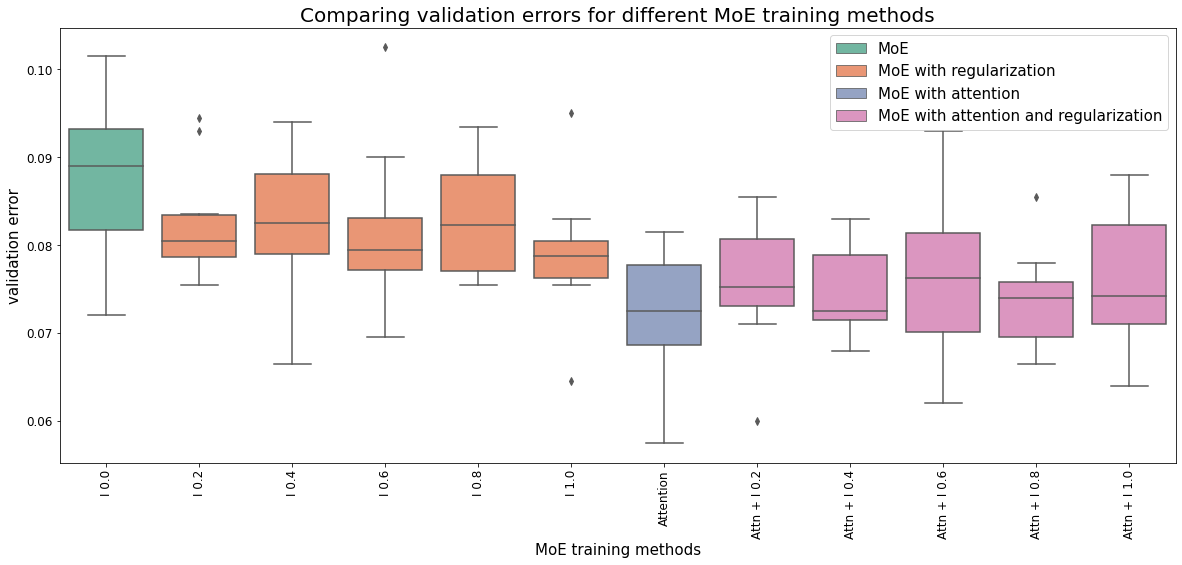

TypeError: unsupported operand type(s) for +=: 'NoneType' and 'str'

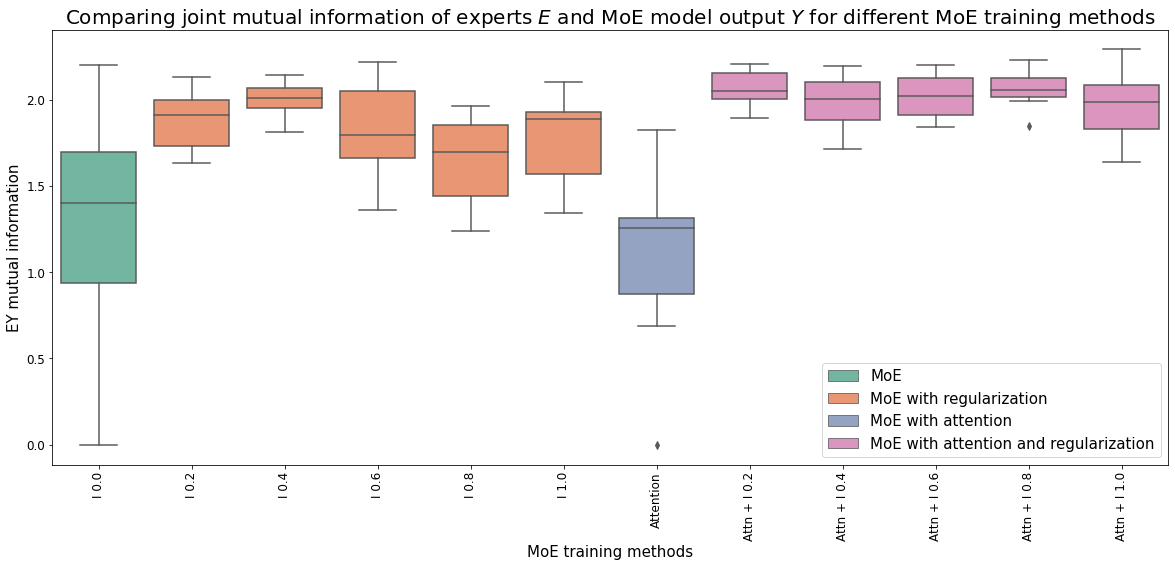

In [86]:
# model_single = 'mnist_single_model_hidden_32'
model_without_reg =  'mnist_without_reg_hidden_32'
model_with_reg = 'mnist_with_reg_hidden_32'
model_with_attention = 'mnist_with_attention_hidden_32'
model_with_attn_reg = 'mnist_with_attn_reg_hidden_32'

total_experts = 5
num_classes = 10
num_epochs = 20

temps = [[1.0]*num_epochs]
print(temps)
w_importance_range = [i * 0.2 for i in range(1, 6)]
print(w_importance_range)

boxplot(model_with_reg=model_with_reg, 
        model_without_reg=model_without_reg, 
        model_with_attention=model_with_attention, 
        model_with_attn_reg=model_with_attn_reg,
        temps=temps, w_importance_range=w_importance_range,
        total_experts=total_experts, num_classes=num_classes, classes=range(num_classes), testloader=testloader)


[1.1 1.2 1.3 1.4 1.5]
[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]


<Figure size 432x288 with 0 Axes>

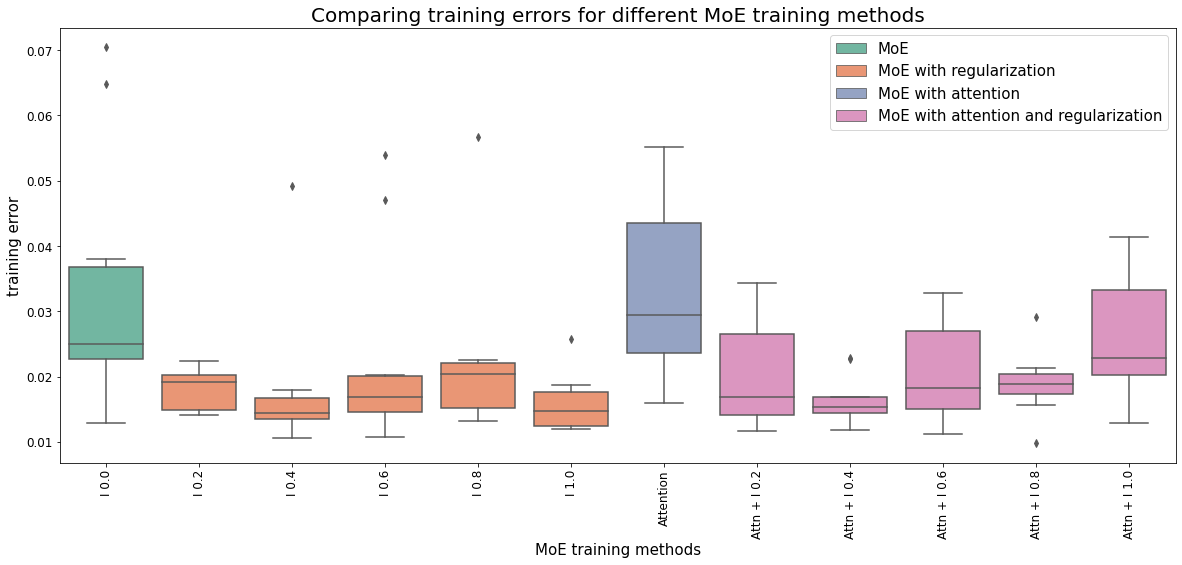

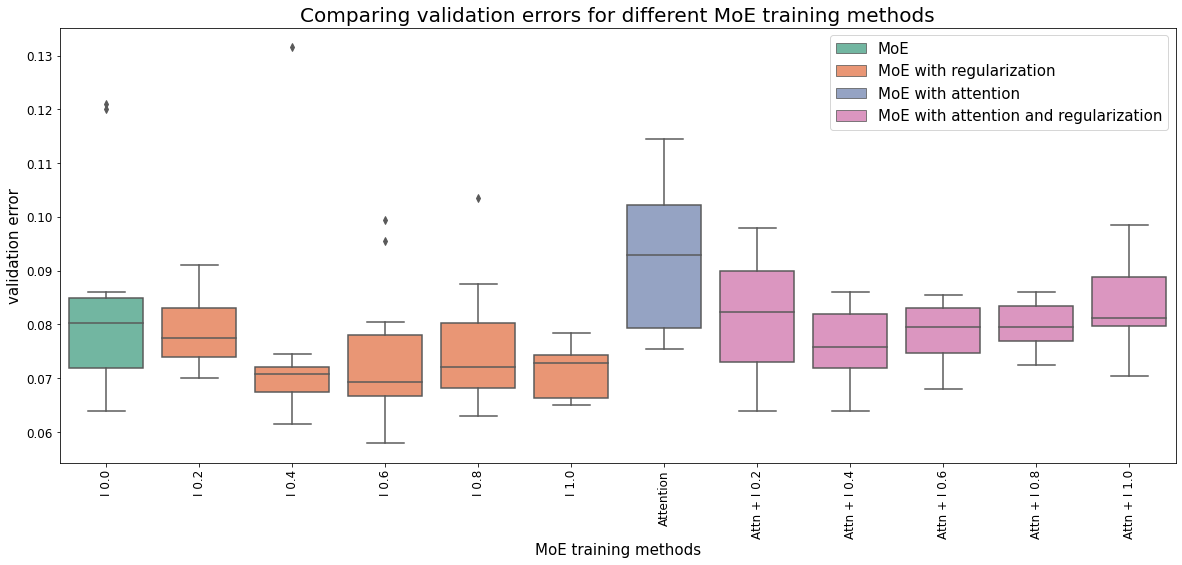

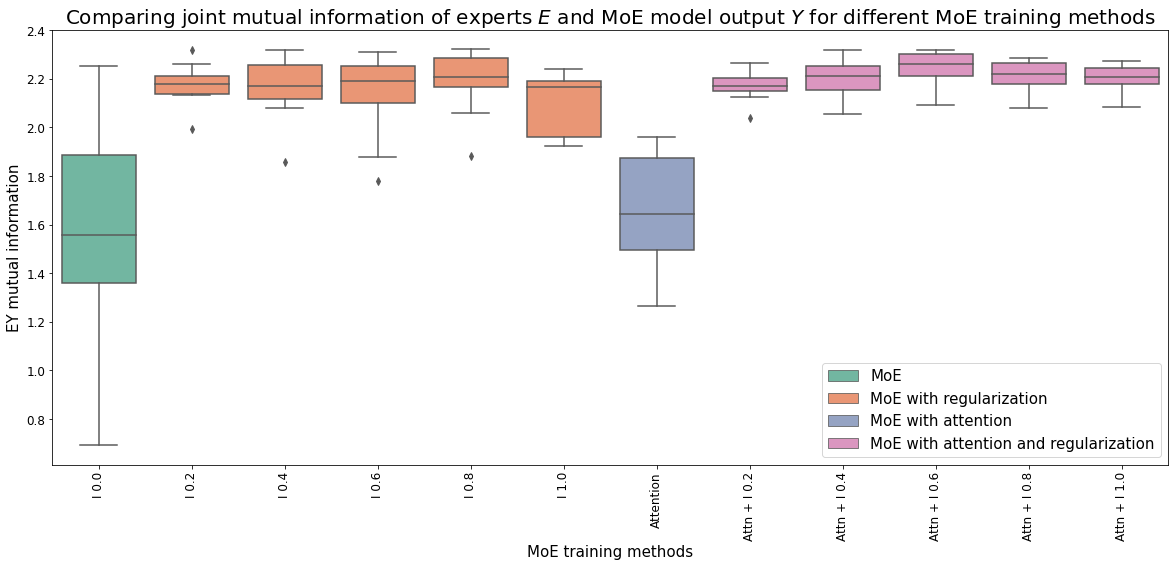

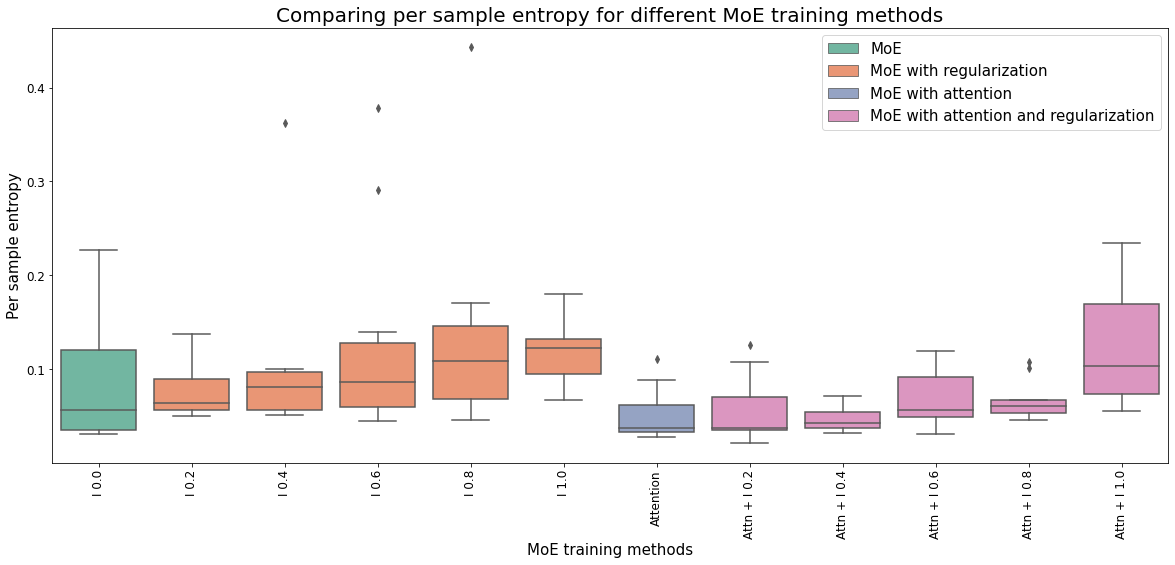

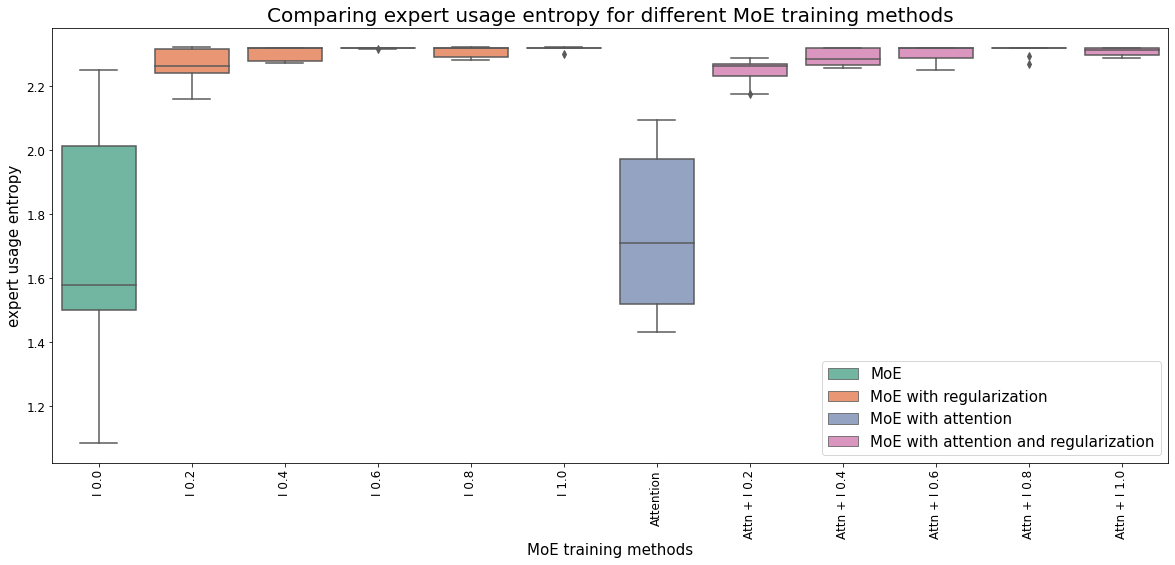

In [66]:
model_without_reg =  model_sample_sim_reg = 'mnist_transform_without_reg'
model_with_reg = 'mnist_transform_with_reg'
model_with_attention = 'mnist_with_attention'
model_with_attn_reg = 'mnist_with_attn_reg'
# model_dual_temp_with_attention = 'mnist_dual_temp_with_attention'
# model_with_temp = 'mnist_dual_temp'
# model_with_reg_temp = 'mnist_dual_temp_with_reg_test'
# mnist_attn_output_reg = 'mnist_attn_output_reg'

total_experts = 5
num_classes = 10

temps = [1.1,1.2]
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 21, 2), np.arange(25, 51, 5)))
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 7, 2)))
temps = np.arange(1.1,1.6,0.1)
print(temps)
w_importance_range = [i * 0.2 for i in range(1, 6)]
print(w_importance_range)

boxplot(
        model_with_reg=model_with_reg, model_without_reg=model_without_reg, 
        model_with_attention=model_with_attention,
        model_with_attn_reg=model_with_attn_reg, 
        temps=temps,w_importance_range=w_importance_range,
        total_experts=total_experts, num_classes=num_classes, classes=range(num_classes), 
        testloader=testloader, figname='mnist_attentive_gate')

In [ ]:
model_single = 'mnist_single_model'
model_with_attention =  'mnist_with_attention'
model_with_temp = 'mnist_dual_temp'
model_with_reg_temp = 'mnist_dual_temp_with_regularization'
model_with_temp_decay = 'mnist_dual_temp_on_schedule'
model_with_reg = 'mnist_with_regularization'
model_without_reg = 'mnist_without_regularization'

total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 6)))
temps = [1.2, 2.0]
w_importance_range = [i * 0.2 for i in range(1, 6)]

boxplot(model_single, model_with_attention, model_with_temp, model_with_temp_decay, model_with_reg, model_without_reg, model_with_reg_temp, temps,w_importance_range,
             total_experts, num_classes, range(num_classes), testloader)

In [ ]:
model_single = 'imbalanced_mnist_single_model'
model_with_temp = 'mnist_imbalanced_5_dual_temp'
model_with_temp_on_delay = 'mnist_imbalanced_5_dual_temp_on_schedule'
model_with_reg = 'mnist_imbalanced_5_with_regularization'
model_without_reg = 'mnist_imbalanced_5_without_regularization'
model_with_reg_temp = 'mnist_imbalanced_5_dual_temp_with_regularization'
total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 6)))
temps = [1.2, 2.0]
w_importance_range = [i * 0.2 for i in range(1, 6)]

boxplot(model_single, model_with_temp, model_with_temp_on_delay, model_with_reg, model_without_reg, model_with_reg_temp, temps,w_importance_range,
             total_experts, num_classes, range(num_classes), testloader)

<Figure size 432x288 with 0 Axes>

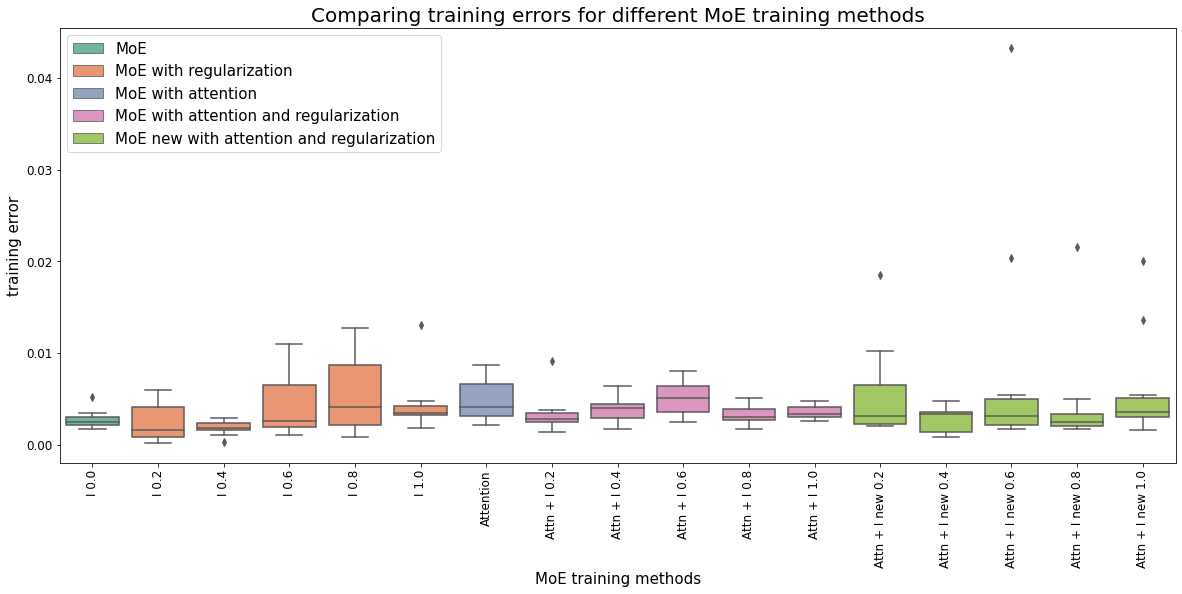

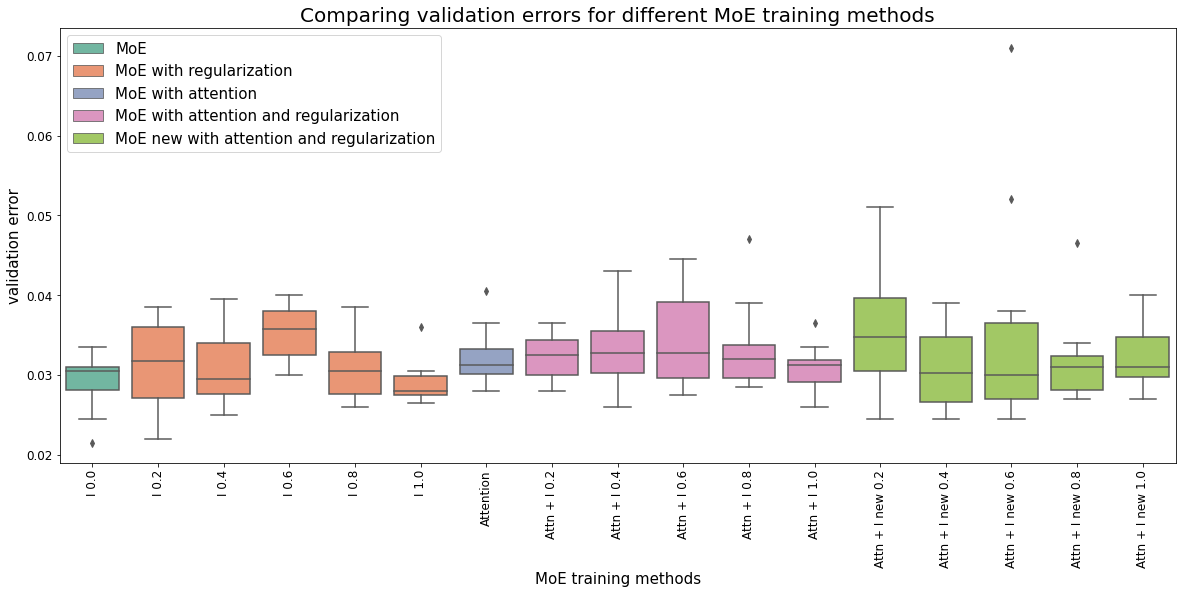

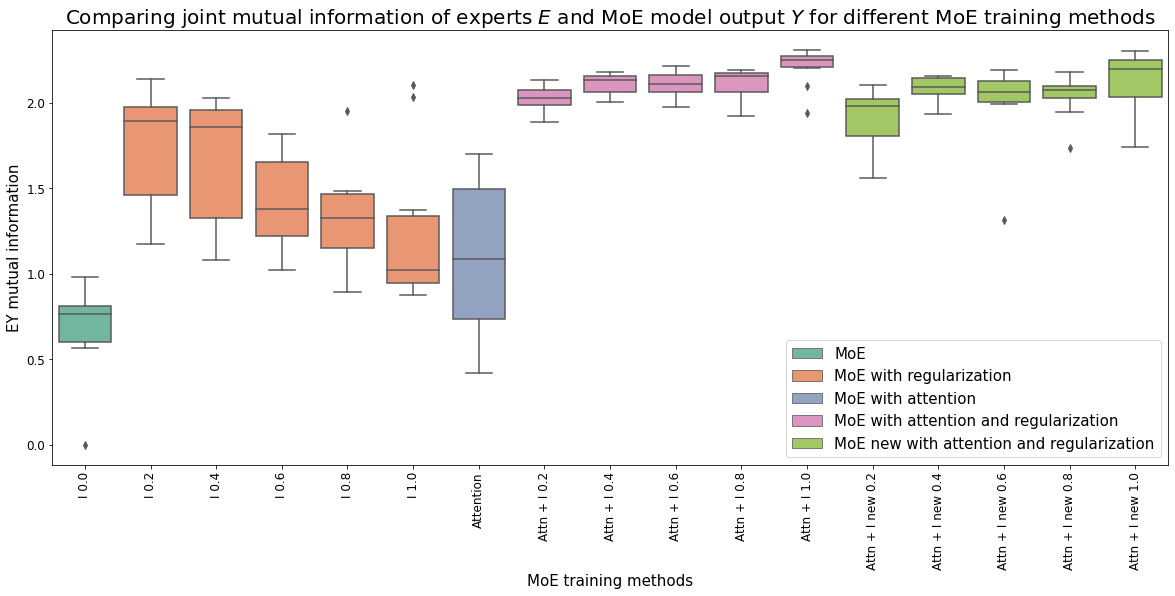

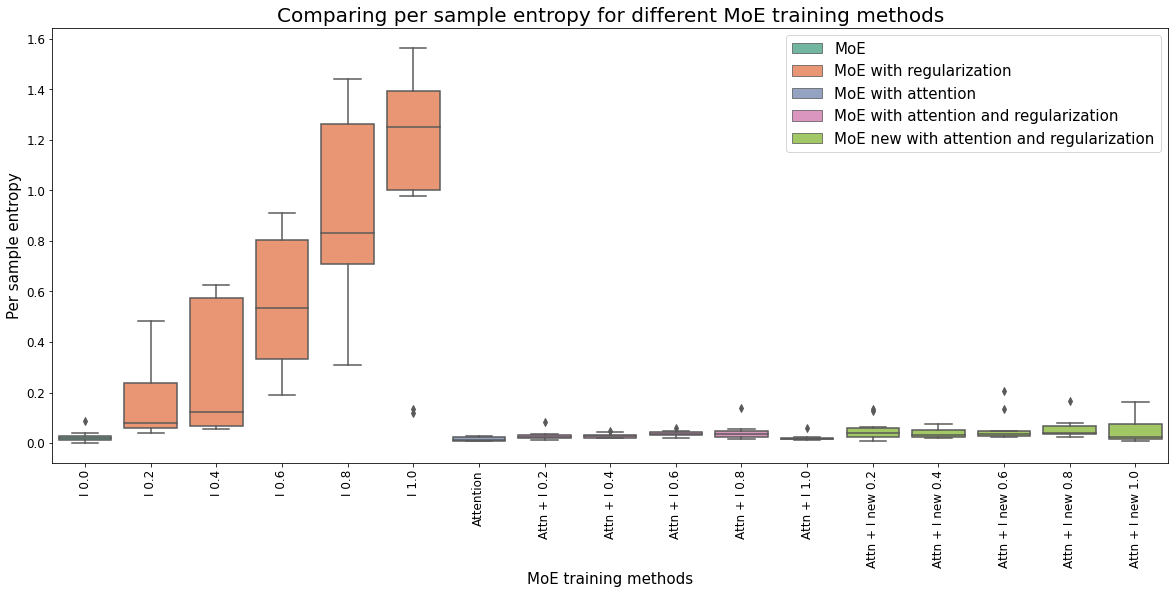

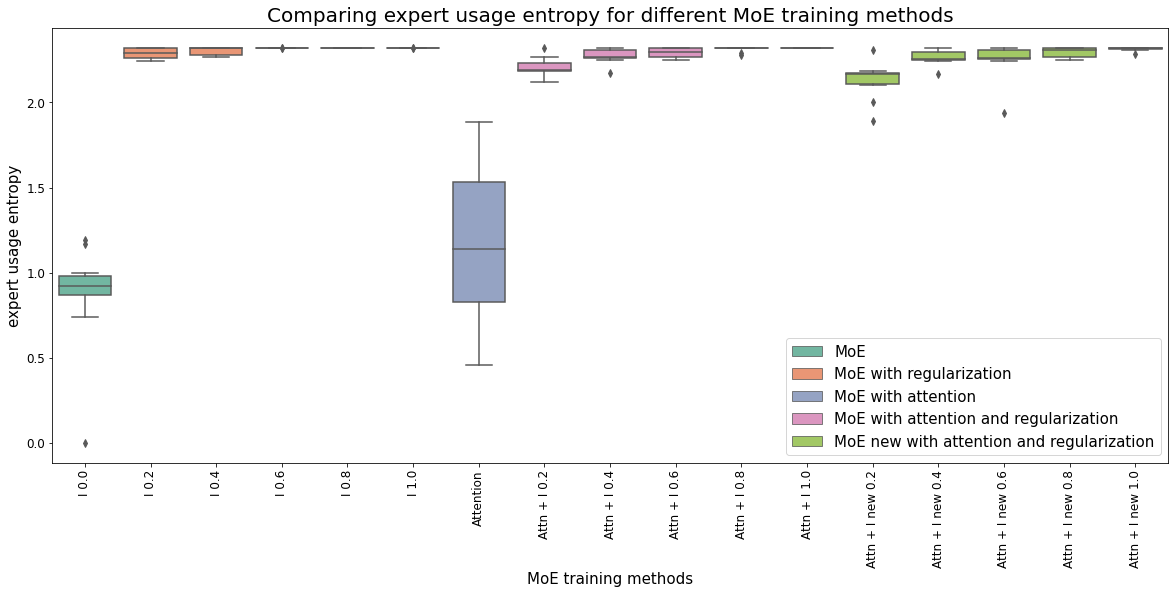

In [54]:
model_with_attention = {'ignore':'rot_mnist_with_attention_hidden_32'}
model_with_attn_reg = {'ignore':'rot_mnist_with_attn_reg_hidden_32', 'new':'new_rot_mnist_with_attn_reg_hidden_32'}
model_with_reg = {'ignore':'rot_mnist_with_reg_hidden_32'}
model_without_reg = {'ignore':'rot_mnist_without_reg_hidden_32'}

figname='rot_mnist_with_attention_hidden_32' 

total_experts = 5
num_classes = 10

w_importance_range = [i * 0.2 for i in range(1, 6)]

boxplot(model_with_reg=model_with_reg, model_without_reg=model_without_reg, model_with_attention=model_with_attention, model_with_attn_reg=model_with_attn_reg,
        w_importance_range=w_importance_range, total_experts=total_experts, num_classes=num_classes, classes=classes_rot_unrot_mnist, 
        testloader=rot_unrot_testloader, figname=figname , fig_path=fig_path, model_path=model_path)

<Figure size 432x288 with 0 Axes>

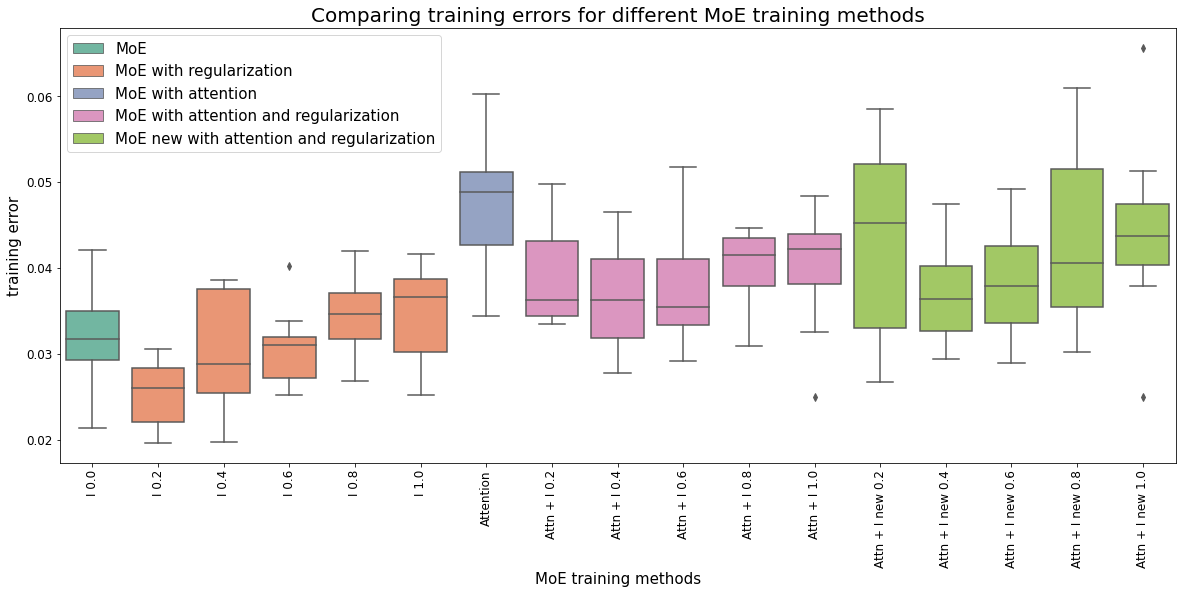

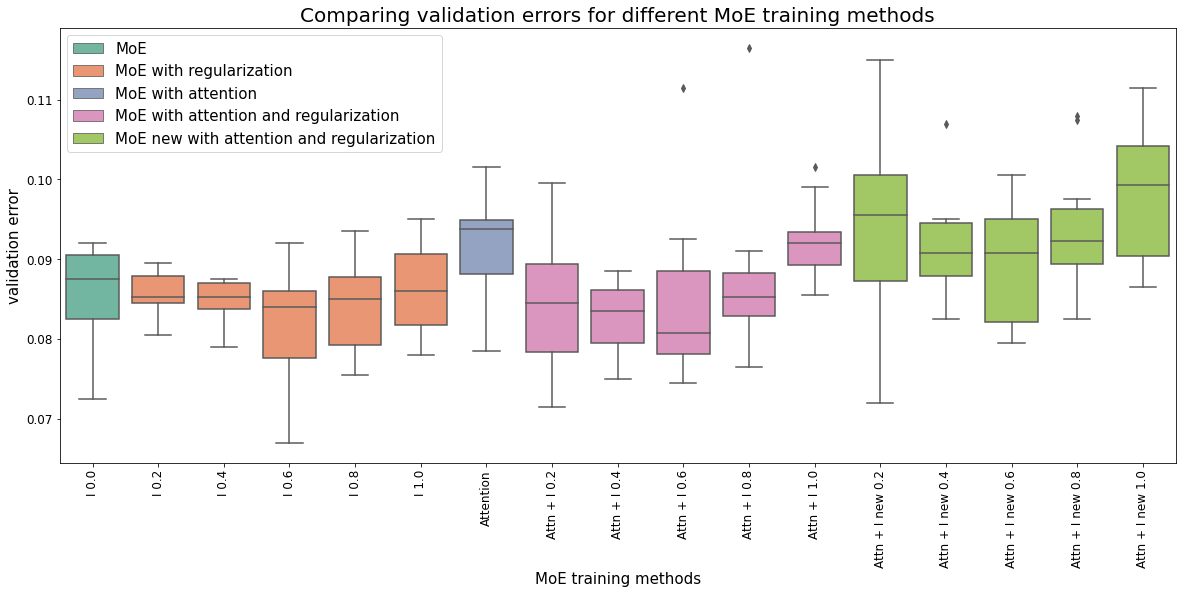

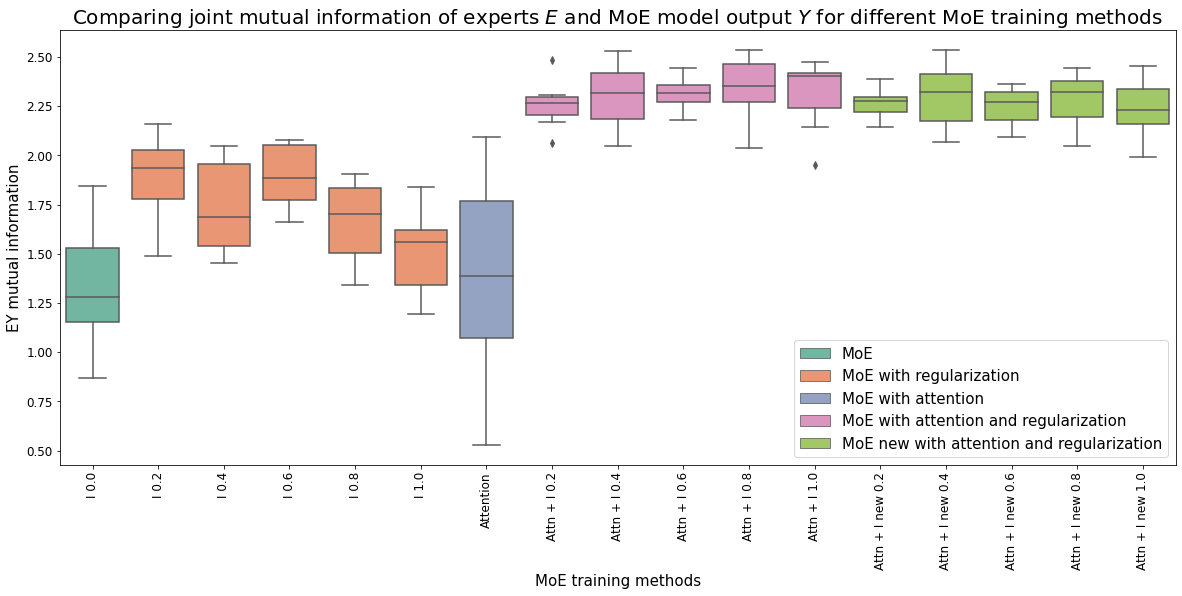

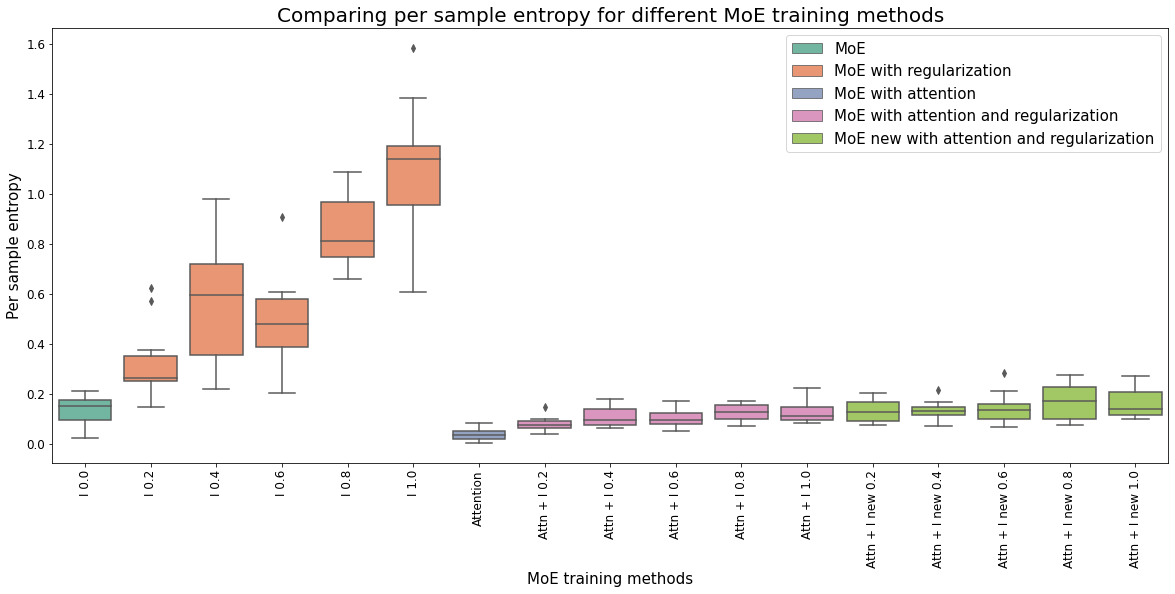

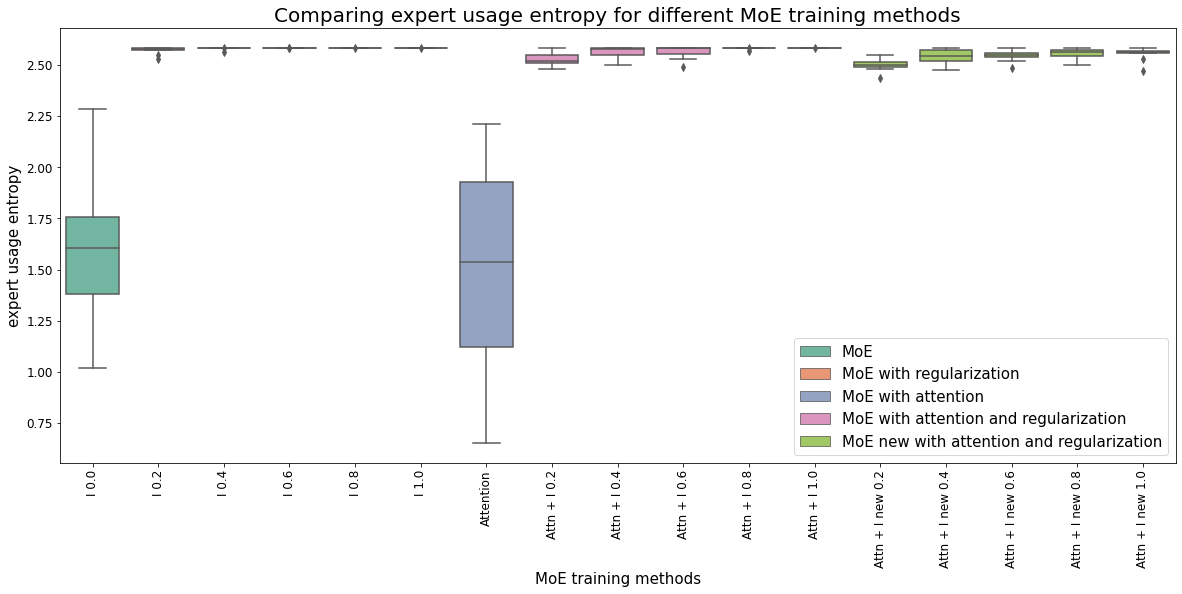

In [91]:
model_with_reg = {'ignore':'fmnist_mnist_with_reg_hidden_32'}
model_without_reg = {'ignore':'fmnist_mnist_without_reg_hidden_32'}
model_with_attention = {'ignore':'fmnist_mnist_with_attention_hidden_32'}
model_with_attn_reg = {'ignore':'fmnist_mnist_with_attn_reg_hidden_32','new':'new_fmnist_mnist_with_attn_reg_hidden_32'}

figname = 'fmnist_mnist_with_attention_hidden_32'
total_experts = 6

w_importance_range = [i * 0.2 for i in range(1, 6)]

boxplot(model_with_reg=model_with_reg, model_without_reg=model_without_reg, model_with_attention=model_with_attention, model_with_attn_reg=model_with_attn_reg,
        w_importance_range=w_importance_range, total_experts=total_experts, num_classes=num_classes_fmnist_mnist, classes=classes_fmnist_mnist, testloader=fmnist_mnist_testloader,
       figname=figname, fig_path=fig_path, model_path=model_path)

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_results(model_with_temp, model_with_reg, model_without_reg, temps, w_importance_range,
                 total_experts, num_classes, classes, testloader):
    
    num_epochs = 20

    min_values = []
    max_values = []
    mean_values = []
    std_values = []
    mutual_info = []
    models = []

    w_importance = 0.0

    for T in temps:    

        m = model_with_temp

        plot_file = generate_plot_file(m, w_importance,'temp_'+"{:.1f}".format(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_models.pt')


        # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
        # model you build above
        model_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

        print('Model:', plot_file)

        error_values = []
        for model in model_1:
            for e_key, e_val in model.items():
                history = model[e_key]['experts'][total_experts]['history']
                error = 1-np.asarray(history['accuracy'])
                error_values.append(error[-1])

        models.append(model_1[np.argmin(error_values)])

        min_values.append("{:.3f}".format(min(error_values)))
        max_values.append("{:.3f}".format(max(error_values)))
        mean_values.append("{:.3f}".format(mean(error_values)))
        std_values.append("{:.3f}".format(np.std(error_values)))
        mutual_info.append("{:.3f}".format(history['mutual_EY'][-1]))

    T = [ 'T '+"{:.1f}".format(t) for t in temps]
    N_T = len(T)

    for w_importance in w_importance_range:

        m = model_with_reg

        plot_file = generate_plot_file(m, w_importance, str(num_classes)+'_'+str(total_experts)+'_models.pt')


        # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
        # model you build above
        model_2 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
        print('Model:', plot_file)

        error_values = []
        for model in model_2:
            for e_key, e_val in model.items():
                history = model[e_key]['experts'][total_experts]['history']
                error = 1-np.asarray(history['accuracy'])
                error_values.append(error[-1])

        models.append(model_2[np.argmin(error_values)])
#         models.append(model_2[-1])

        min_values.append("{:.3f}".format(min(error_values)))
        max_values.append("{:.3f}".format(max(error_values)))
        mean_values.append("{:.3f}".format(mean(error_values)))
        std_values.append("{:.3f}".format(np.std(error_values)))
        mutual_info.append("{:.3f}".format(history['mutual_EY'][-1]))

    N_I = len(w_importance_range)
    I = [ 'I '+"{:.1f}".format(i) for i in w_importance_range]

    m = model_without_reg

    plot_file = generate_plot_file(m, 0.0, str(num_classes)+'_'+str(total_experts)+'_models.pt')


    # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
    # model you build above
    model_3 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
    print('Model:', plot_file)

    error_values = []
    for model in model_3:
        history = model[e_key]['experts'][total_experts]['history']
        for e_key, e_val in model.items():
            error = 1-np.asarray(history['accuracy'])
            error_values.append(error[-1])

    models.append(model_3[np.argmin(error_values)])
#     models.append(model_3[-1])
    
    min_values.append("{:.3f}".format(min(error_values)))
    max_values.append("{:.3f}".format(max(error_values)))
    mean_values.append("{:.3f}".format(mean(error_values)))
    std_values.append("{:.3f}".format(np.std(error_values)))
    mutual_info.append("{:.3f}".format(history['mutual_EY'][-1]))

    method = T + I + ['I 0.0']
    N = N_T + N_I + 1

    print('N',N)
    data = np.hstack((np.asarray(method).reshape(N,1), np.asarray(min_values).reshape(N,1), np.asarray(max_values).reshape(N,1), 
                      np.asarray(mean_values).reshape(N,1), np.asarray(std_values).reshape(N,1), 
                      np.asarray(mutual_info).reshape(N,1)))

    print(data.shape)

    columns = ['Method', 'Min', 'Max', 'Mean', 'Std', 'Mutual Info']
    colors = np.array([['w']*len(columns)]*N)
    colors[np.argmin(data[:,1]), 1] = 'y'
    colors[np.argmax(data[:,2]), 2] = 'y'
    colors[np.argmin(data[:,3]), 3] = 'y'
    colors[np.argmin(data[:,4]), 4] = 'y'
    colors[np.argmax(data[:,5]), 5] = 'y'

    fig, ax = plt.subplots()
    # hide axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    ax.table(cellText=data, colLabels=columns, cellColours=colors, loc='center')

    fig.tight_layout()

    plt.show()


    model = models[np.argmin(data[0:N_T,1])]

    fig1,ax1 = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12, 4))
    ax1.flatten()

    # Plotting for the model with reg
    for e_key, e_val in model.items():


        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                moe_model = e_val['experts'][total_experts]['model']

                # predict the classes for test data
                pred = moe_model(images)
                pred_labels = torch.argmax(pred, dim=1)

                expert_outputs = moe_model.expert_outputs
                gate_outputs = moe_model.gate_outputs

                # get the experts selected by the gate for each sample
                pred_gate_labels = torch.argmax(gate_outputs, dim=1)

                # plot the expert selection table
                print('\nExperts used by the gate for classification of each digit')
                class_expert_table = np.asarray([[0] * num_classes]*total_experts)
                for label, expert in zip(labels, pred_gate_labels):
                    class_expert_table[expert,label] += 1
                sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                            xticklabels=[classes[i] for i in range(0, num_classes)],
                            annot=True, cmap=cmap, fmt='d', ax=ax1[0])

                sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1[1], cmap=cmap, fmt='d')

                plt.show()


    model = models[N_T+np.argmin(data[N_T:N-1,1])]
    
    fig1,ax1 = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12, 4))
    ax1.flatten()

    # Plotting for the model without reg
    for e_key, e_val in model.items():
        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                moe_model = e_val['experts'][total_experts]['model']

                # predict the classes for test data
                pred = moe_model(images)
                pred_labels = torch.argmax(pred, dim=1)

                expert_outputs = moe_model.expert_outputs
                gate_outputs = moe_model.gate_outputs

                # get the experts selected by the gate for each sample
                pred_gate_labels = torch.argmax(gate_outputs, dim=1)

                # plot the expert selection table
                print('\nExperts used by the gate for classification of each digit')
                class_expert_table = np.asarray([[0] * num_classes]*total_experts)
                for label, expert in zip(labels, pred_gate_labels):
                    class_expert_table[expert,label] += 1
                sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                            xticklabels=[classes[i] for i in range(0, num_classes)],
                            annot=True, cmap=cmap, fmt='d', ax=ax1[0])

                sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1[1], cmap=cmap, fmt='d')

                plt.show()

    model = models[-1]

    fig1,ax1 = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12, 4))
    ax1.flatten()

    # Plotting for the model without reg
    for e_key, e_val in model.items():
        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                moe_model = e_val['experts'][total_experts]['model']

                # predict the classes for test data
                pred = moe_model(images)
                pred_labels = torch.argmax(pred, dim=1)

                expert_outputs = moe_model.expert_outputs
                gate_outputs = moe_model.gate_outputs

                # get the experts selected by the gate for each sample
                pred_gate_labels = torch.argmax(gate_outputs, dim=1)

                # plot the expert selection table
                print('\nExperts used by the gate for classification of each digit')
                class_expert_table = np.asarray([[0] * num_classes]*total_experts)
                for label, expert in zip(labels, pred_gate_labels):
                    class_expert_table[expert,label] += 1
                sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                            xticklabels=[classes[i] for i in range(0, num_classes)],
                            annot=True, cmap=cmap, fmt='d', ax=ax1[0])

                sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1[1], cmap=cmap, fmt='d')

                plt.show()

    # plot error rates
    fig2,ax2 = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(16,4))
    ax2 = ax2.flatten()

    fig3,ax3 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))

    fig4,ax4 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))
    
    fig5,ax5 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))

    for i, model in enumerate(models):
        for e_key, e_val in model.items():

            # plot training and validation error rates
            sns.lineplot(x=range(num_epochs), y=1-np.asarray(model[e_key]['experts'][total_experts]['history']['accuracy']), ax=ax2[0])
            sns.lineplot(x=range(num_epochs), y=1-np.asarray(model[e_key]['experts'][total_experts]['history']['val_accuracy']), ax=ax2[1])

            # plot training loss
            sns.lineplot(x=range(num_epochs), y=np.asarray(model[e_key]['experts'][total_experts]['history']['loss']), ax=ax3)

            # plot mutual information
            sns.lineplot(x=range(num_epochs), y=np.asarray(model[e_key]['experts'][total_experts]['history']['mutual_EY']), ax=ax4)

            # plot mutual information
            sns.lineplot(x=range(num_epochs), y=np.asarray(model[e_key]['experts'][total_experts]['history']['H_EY']), ax=ax5)

    legend = data[:,0]

    ax2[0].legend(legend)

    ax2[0].set_xlabel('epochs')
    ax2[0].set_xticks(range(num_epochs+1))
    ax2[0].set_ylabel('train error rate')
    ax2[0].set_ylim(ymin=0)


    ax2[1].legend(legend)

    ax2[1].set_xlabel('epochs')
    ax2[1].set_xticks(range(num_epochs+1))
    ax2[1].set_ylabel('validation error rate')
    ax2[1].set_ylim(ymin=0)


    ax3.legend(legend)

    ax3.set_xlabel('epochs')
    ax3.set_xticks(range(num_epochs+1))
    ax3.set_ylabel('training loss')
    ax3.set_ylim(ymin=0)

    ax4.legend(legend)

    ax4.set_xlabel('epochs')
    ax4.set_xticks(range(num_epochs+1))
    ax4.set_ylabel('mutual information')
    ax4.set_ylim(ymin=0)
    
    ax5.legend(legend)

    ax5.set_xlabel('epochs')
    ax5.set_xticks(range(num_epochs+1))
    ax5.set_ylabel('Entropy EY')
    ax5.set_ylim(ymin=0)

    plt.show()


### Results for MNIST data

In [ ]:
model_with_temp = 'mnist_dual_temp'
model_with_reg = 'mnist_with_regularization'
model_without_reg = 'mnist_without_regularization'
total_experts = 5
num_classes = 10
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

plot_results(model_with_temp, model_with_reg, model_without_reg, temps,w_importance_range,
             total_experts, num_classes, range(num_classes), testloader)

In [ ]:
model_with_temp = 'mnist_imbalanced_5_dual_temp'
model_with_reg = 'mnist_imbalanced_5_with_regularization'
model_without_reg = 'mnist_imbalanced_5_without_regularization'
total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

plot_results(model_with_temp, model_with_reg, model_without_reg, temps,w_importance_range,
             total_experts, num_classes, range(num_classes), testloader)

In [ ]:
model_with_temp = 'rot_mnist_dual_temp'
model_with_reg = 'rot_mnist_with_regularization'
model_without_reg = 'rot_mnist_without_regularization'
total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

rot_unrot_mnist_classes = ['0','1','2','3','4','rotated 0', 'rotated 1', 'rotated 2', 'rotated 3', 'rotated 4']
plot_results(model_with_temp, model_with_reg, model_without_reg, temps, w_importance_range,
             total_experts, num_classes,rot_unrot_mnist_classes , rot_unrot_testloader)

### Results for combined FMNIST and MNIST data

In [ ]:
model_with_temp = 'fmnist_mnist_dual_temp'
model_with_reg = 'fmnist_mnist_with_regularization'
model_without_reg = 'fmnist_mnist_without_regularization'
total_experts = 6

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

plot_results(model_with_temp, model_with_reg, model_without_reg, temps, w_importance_range,
             total_experts, num_classes_fmnist_mnist, classes_fmnist_mnist, fmnist_mnist_testloader)

In [ ]:
def plot_gate_prob(model_with_temp, model_with_reg, model_without_reg, temps, w_importance_range,
                 total_experts, num_classes, classes, testloader):
    
    w_importance = 0.0
    
    for T in temps:    

        m = model_with_temp

        plot_file = generate_plot_file(m, w_importance,'temp_'+"{:.1f}".format(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_models.pt')


        # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
        # model you build above
        model = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)[5]
        
        for e_key, e_val in model.items():
            history = model[e_key]['experts'][total_experts]['history']
            mean_gate_probability = np.asarray(history['mean_gate_probability'])
            var_gate_probability = np.asarray(history['var_gate_probability'])
            print('Temperature ', "{:.1f}".format(T))
            print(mean_gate_probability.shape)
            plt.imshow(np.transpose(mean_gate_probability))
            plt.show()
            plt.imshow(np.transpose(var_gate_probability))
            plt.show()
        
    

#     for w_importance in w_importance_range:

#         m = model_with_reg

#         plot_file = generate_plot_file(m, w_importance, str(num_classes)+'_'+str(total_experts)+'_models.pt')


#         # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
#         # model you build above
#         model_2 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
# #         print('Model:', plot_file)

#         error_values = []
#         for model in model_2:
#             for e_key, e_val in model.items():
#                 history = model[e_key]['experts'][total_experts]['history']
#                 error = 1-np.asarray(history['accuracy'])
#                 val_error = 1-np.asarray(history['val_accuracy'])
#                 y_error.append(error[-1])
#                 y_val_error.append(val_error[-1])
#                 y_mi.append(history['mutual_EY'][-1])
#                 y_H_EY.append(history['H_EY'][-1])
#                 y_sample_H.append(history['sample_entropy'][-1])
#                 x.append('I '+"{:.1f}".format(w_importance))


In [ ]:
model_with_temp = 'fmnist_mnist_dual_temp'
model_with_reg = 'fmnist_mnist_with_regularization'
model_without_reg = 'fmnist_mnist_without_regularization'
total_experts = 6
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]
plot_gate_prob(model_with_temp, model_with_reg, model_without_reg, temps,w_importance_range,
             total_experts, num_classes_fmnist_mnist, classes_fmnist_mnist, fmnist_mnist_testloader)